In [1]:
import mlflow
from mlflow.tracking.client import MlflowClient
import re

In [2]:
mlflow.set_tracking_uri('file:///home/akira/akira/p-poteka-analysis/mlruns')

In [3]:
exprs = mlflow.get_experiment("8")
exprs.name

'important_feats_2'

In [4]:
eval_runs = MlflowClient().search_runs("8", filter_string="tags.mlflow.project.entryPoint = 'evaluate'")
eval_runs[0]

<Run: data=<RunData: metrics={'All_sample_RMSE': 6.213209286794329,
 'NOT_TC_case_2019-10-04_4-0_start': 10.226389359560555,
 'NOT_TC_case_2019-10-04_5-0_start': 7.735997117851546,
 'NOT_TC_case_2019-10-04_6-0_start': 2.908987363582297,
 'NOT_TC_case_2019-10-04_7-0_start': 0.6526544375202047,
 'NOT_TC_case_2019-10-12_10-0_start': 4.487246099285791,
 'NOT_TC_case_2019-10-12_8-0_start': 18.991134175168668,
 'NOT_TC_case_2019-10-12_9-0_start': 14.850289600617971,
 'NOT_TC_case_2020-07-04_10-0_start': 0.5253759115955436,
 'NOT_TC_case_2020-07-04_6-0_start': 7.039613294303411,
 'NOT_TC_case_2020-07-04_7-0_start': 15.089103932468902,
 'NOT_TC_case_2020-07-04_8-0_start': 14.856468176072894,
 'NOT_TC_case_2020-07-04_9-0_start': 4.355828209874603,
 'One_Hour_Prediction_RMSE': 2.54794632519857,
 'Sequential_NOT_TC_case_2019-10-04_4-0_start': 2.4696047442035325,
 'Sequential_NOT_TC_case_2019-10-04_5-0_start': 1.7939306419558558,
 'Sequential_NOT_TC_case_2019-10-04_6-0_start': 0.6142145842908289,


In [5]:
len(eval_runs)

14

In [6]:
# One value metric pattern
all_sample_rmse_pattern = "All_sample_RMSE"
ten_minutes_prediction_rmse_pattern = "One_Hour_Prediction_RMSE"

# Mluitple vlayues metric pattern 
## TC case
tc_case_regex = "^TC_case_.+"
seq_tc_case_regex = "^Sequential_TC_case_.+"

## NOT TC case
not_tc_case_regex = "^NOT_TC_case_.+"
seq_not_tc_case_regex = "^Sequential_NOT_TC_case_.+"

# R2 score
r2_regex = "^r2_.+"

In [7]:
from typing import Dict, List

all_sample_rmse: Dict[str, float] = {}
ten_minutes_prediction_rmse: Dict[str, float] = {}

tc_case_rmses: Dict[str, list] = {}
seq_tc_case_rmses: Dict[str, list] = {}

not_tc_case_rmses: Dict[str, list] = {}
seq_not_tc_case_rmses: Dict[str, list] = {}

r2_scores: Dict[str, float] = {}

def get_metrics_list(mlflow_metrics_history: List[mlflow.entities.Metric]) -> Dict:
    res = {}
    for metric in mlflow_metrics_history:
        res[str(metric.step)] = metric.value
    return res
        
for run in eval_runs:
    metrics_key = run.data.tags["mlflow.runName"].replace("_evaluation", "")
    
    tc_case_rmses[metrics_key] = {}
    seq_tc_case_rmses[metrics_key] = {}
    
    not_tc_case_rmses[metrics_key] = {}
    seq_not_tc_case_rmses[metrics_key] = {}
    
    r2_scores[metrics_key] = {}
    
    # Get Metrics
    metrics: Dict[str, float] = run.data.metrics
    for key, val in metrics.items():
        if key == all_sample_rmse_pattern:
            all_sample_rmse[metrics_key] = val
        elif key == ten_minutes_prediction_rmse_pattern:
            ten_minutes_prediction_rmse[metrics_key] = val
        
        elif re.match(tc_case_regex, key) is not None:
            metrics_history = MlflowClient().get_metric_history(run.info.run_id, key)
            tc_case_rmses[metrics_key][key] = get_metrics_list(metrics_history)
        elif re.match(seq_tc_case_regex, key) is not None:
            metrics_history = MlflowClient().get_metric_history(run.info.run_id, key)
            seq_tc_case_rmses[metrics_key][key] = get_metrics_list(metrics_history)
        
        elif re.match(not_tc_case_regex, key) is not None:
            metrics_history = MlflowClient().get_metric_history(run.info.run_id, key)
            not_tc_case_rmses[metrics_key][key] = get_metrics_list(metrics_history)
            
        elif re.match(seq_not_tc_case_regex, key) is not None:
            metrics_history = MlflowClient().get_metric_history(run.info.run_id, key)
            seq_not_tc_case_rmses[metrics_key][key] = get_metrics_list(metrics_history)
            
        if re.match(r2_regex, key) is not None:
            r2_scores[metrics_key][key] = val

In [8]:
# Validate metrics
from unittest import TestCase

test_mod = TestCase()

parameter_pattern_counts = 14
test_case_counts = 12

test_mod.assertEqual(len(all_sample_rmse), parameter_pattern_counts)
test_mod.assertEqual(len(ten_minutes_prediction_rmse), parameter_pattern_counts)

test_mod.assertEqual(len(tc_case_rmses), parameter_pattern_counts)
for metrics_history in [tc_case_rmses[i] for i in tc_case_rmses.keys()]:
    with test_mod.subTest(metrics_history=metrics_history):
        test_mod.assertEqual(len(metrics_history), test_case_counts)
        
test_mod.assertEqual(len(seq_tc_case_rmses), parameter_pattern_counts)
for metrics_histotry in [seq_tc_case_rmses[i] for i in seq_tc_case_rmses.keys()]:
    with test_mod.subTest(metrics_history=metrics_history):
        test_mod.assertEqual(len(metrics_history), test_case_counts)
        
test_mod.assertEqual(len(not_tc_case_rmses), parameter_pattern_counts)
for metrics_history in [not_tc_case_rmses[i] for i in not_tc_case_rmses.keys()]:
    with test_mod.subTest(metrics_history=metrics_history):
        test_mod.assertEqual(len(metrics_history), test_case_counts)
        
test_mod.assertEqual(len(seq_not_tc_case_rmses), parameter_pattern_counts)
for metrics_history in [seq_not_tc_case_rmses[i] for i in seq_not_tc_case_rmses.keys()]:
    with test_mod.subTest(metrics_history=metrics_history):
        test_mod.assertEqual(len(metrics_history), test_case_counts)
        
test_mod.assertEqual(len(r2_scores), parameter_pattern_counts)

In [9]:
# Visualze result
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

all_sample_rmse_df = pd.DataFrame({"tag": all_sample_rmse.keys(), "value": all_sample_rmse.values()})
all_sample_rmse_df = all_sample_rmse_df.set_index("tag")
print(all_sample_rmse_df.sort_values("value", ascending=True))

                                        value
tag                                          
RainTemperatureHumidity              6.196410
RainWind                             6.213209
RainTemperatureHumidityWindAbs_wind  6.217096
RainTemperatureHumidityWind          6.218409
RainHumidityWind                     6.246572
RainHumidityWindAbs_wind             6.268401
RainTemperature                      6.308401
RainHumidityAbs_wind                 6.308403
RainHumidity                         6.311859
RainTemperatureWind                  6.323333
RainTemperatureAbs_wind              6.385397
Rain                                 6.426046
RainTemperatureWindAbs_wind          6.439511
RainTemperatureHumidityAbs_wind      6.658024


In [10]:
ten_minutes_prediction_rmse_df = pd.DataFrame({"tag": ten_minutes_prediction_rmse.keys(), "value": ten_minutes_prediction_rmse.values()})
ten_minutes_prediction_rmse_df = ten_minutes_prediction_rmse_df.set_index("tag")
print(ten_minutes_prediction_rmse_df.sort_values("value", ascending=True))

                                        value
tag                                          
RainTemperature                      2.392376
Rain                                 2.399923
RainTemperatureHumidity              2.475198
RainHumidityWind                     2.517246
RainHumidity                         2.530552
RainTemperatureHumidityWind          2.545974
RainWind                             2.547946
RainTemperatureWind                  2.555296
RainTemperatureAbs_wind              2.593121
RainTemperatureHumidityAbs_wind      2.713817
RainTemperatureWindAbs_wind          2.731377
RainHumidityAbs_wind                 2.742987
RainHumidityWindAbs_wind             2.762109
RainTemperatureHumidityWindAbs_wind  2.798531


<AxesSubplot:xlabel='all prediction', ylabel='ten minutes prediction'>

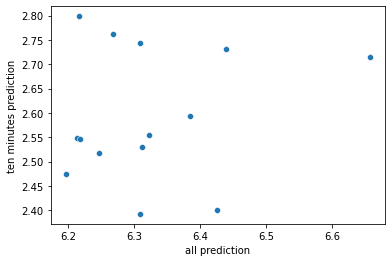

In [11]:
df = pd.concat([all_sample_rmse_df, ten_minutes_prediction_rmse_df], axis=1)
df.columns = ["all prediction", "ten minutes prediction"]
sns.scatterplot(data=df, x="all prediction", y="ten minutes prediction")

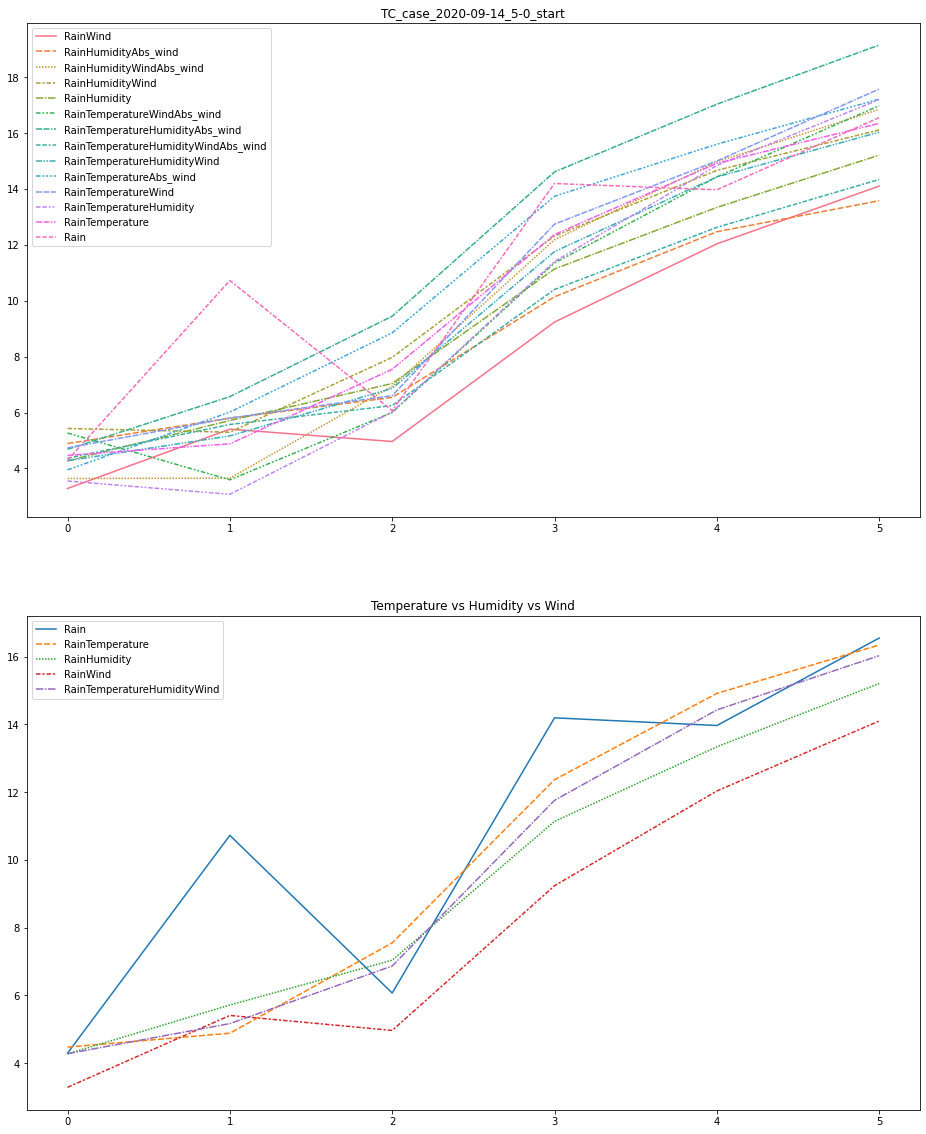

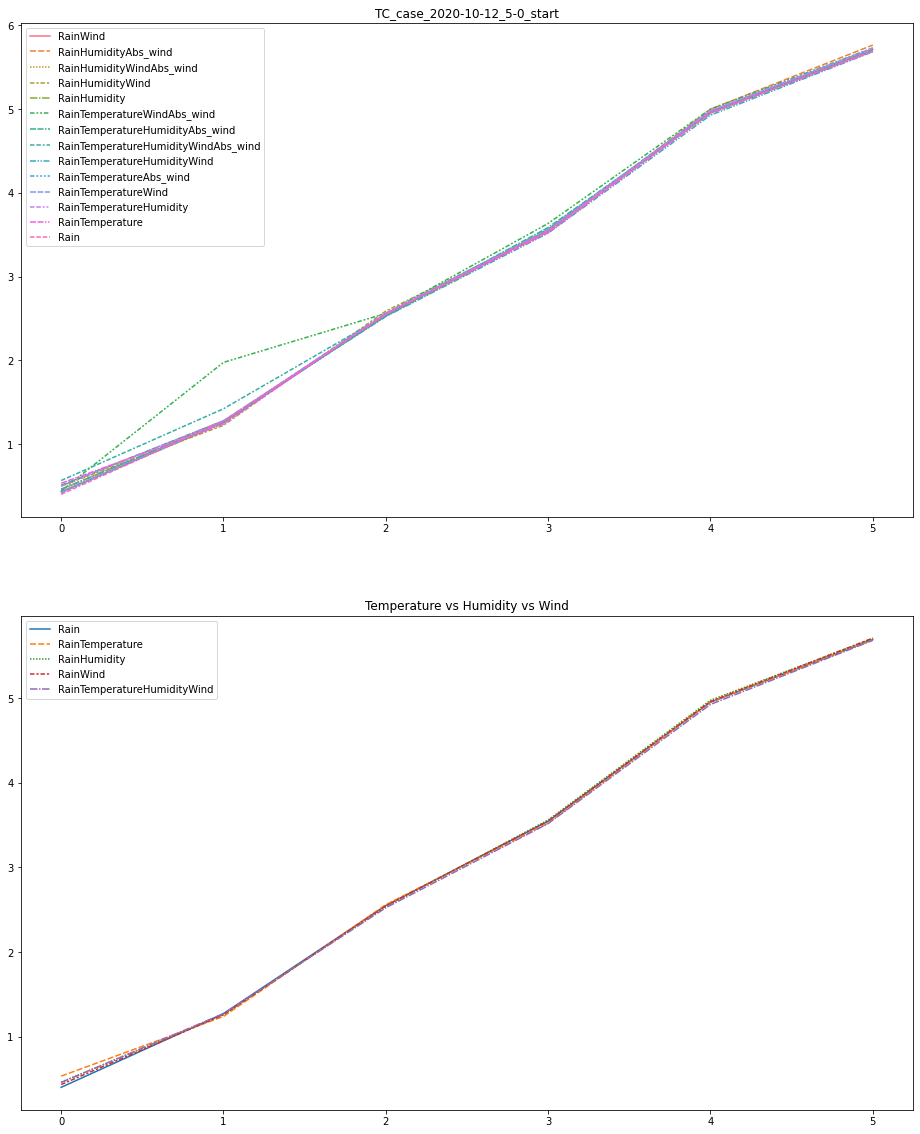

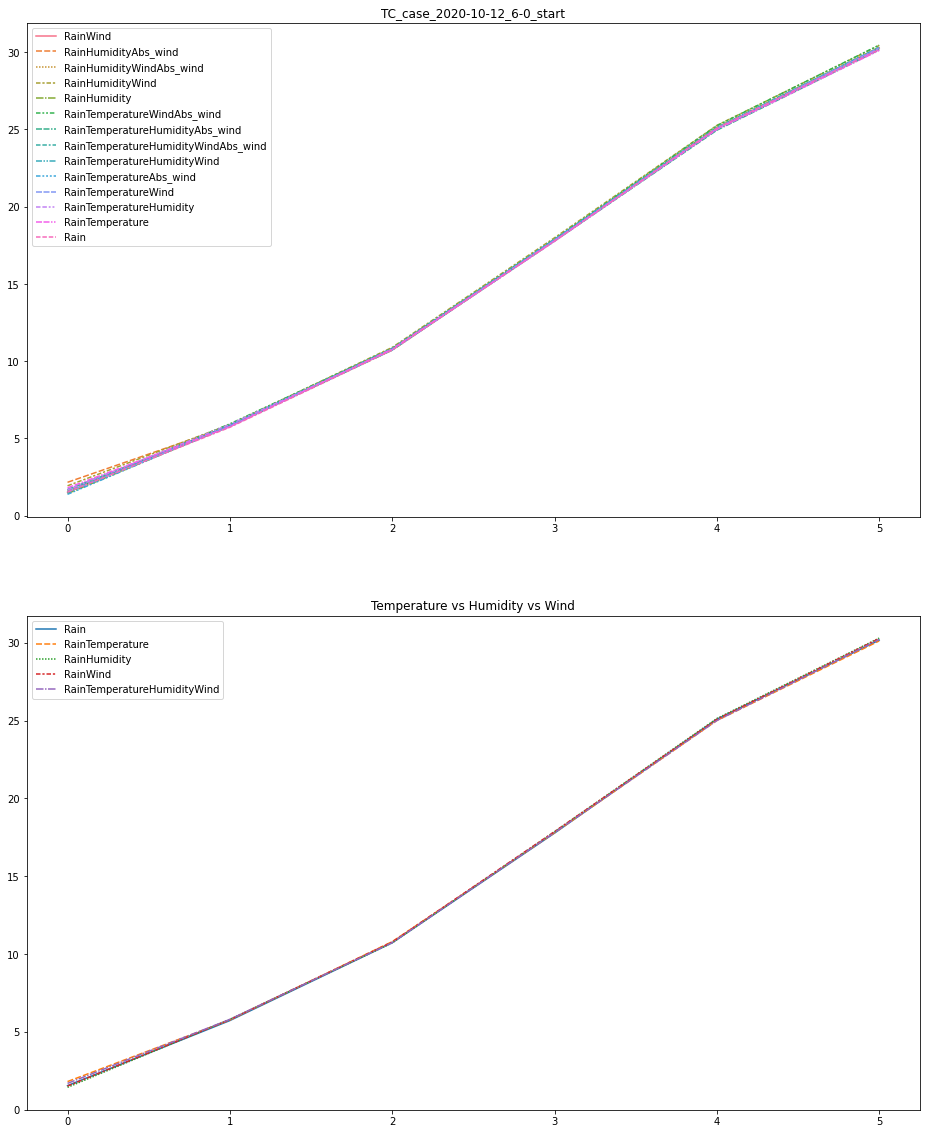

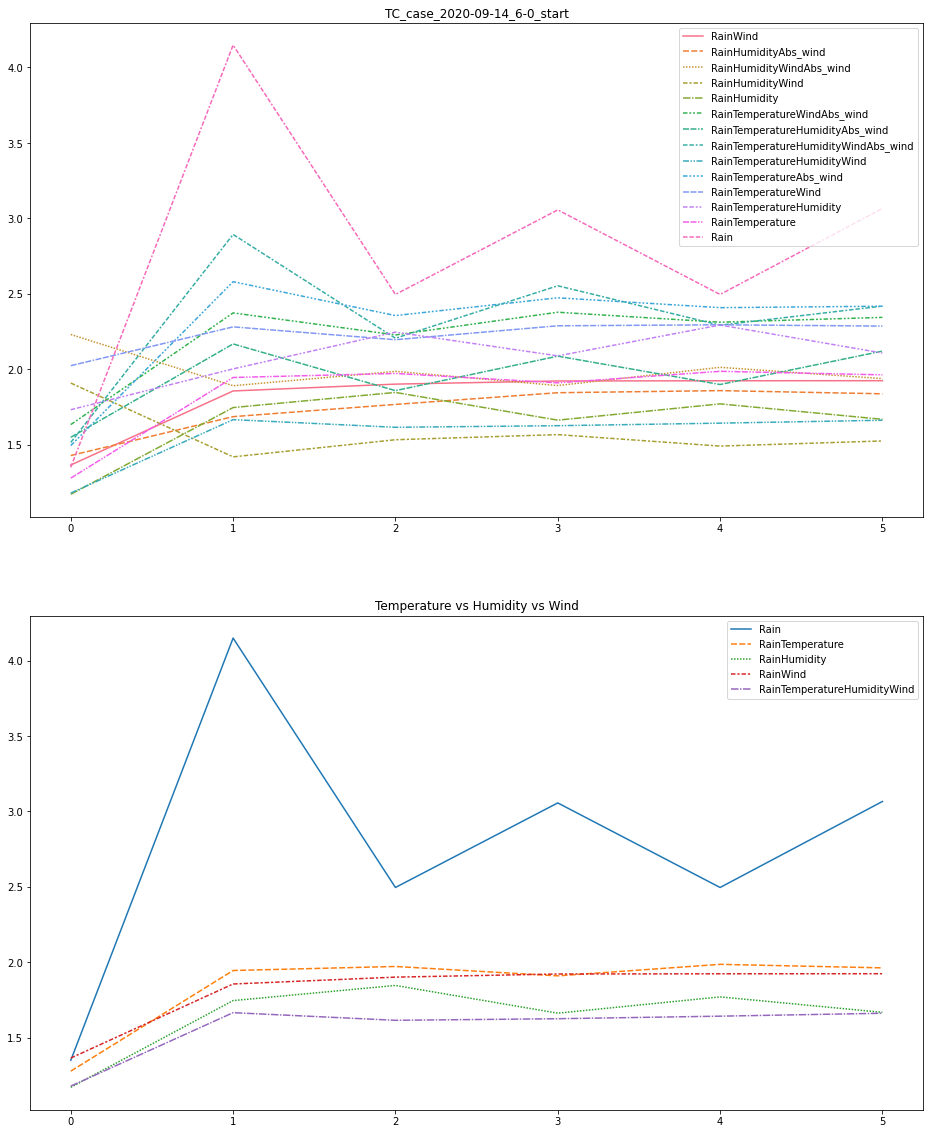

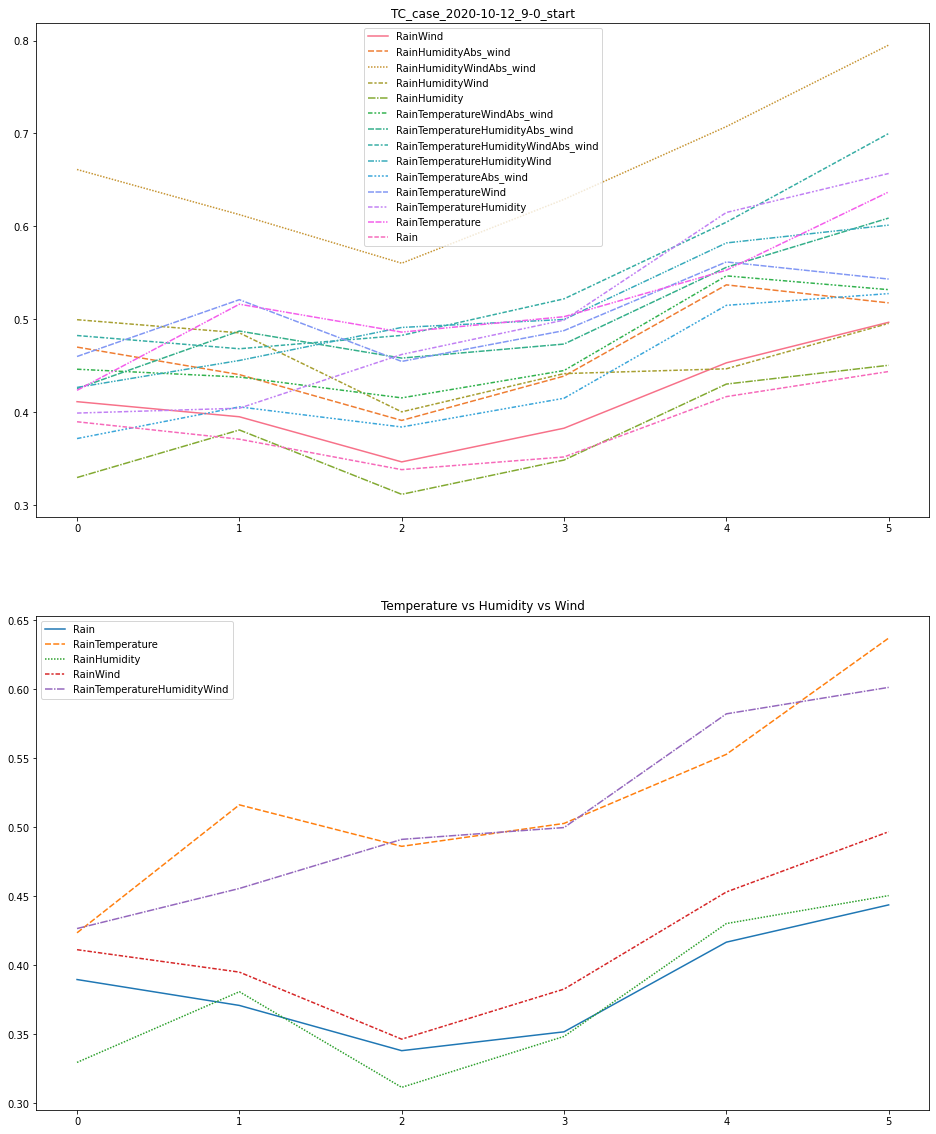

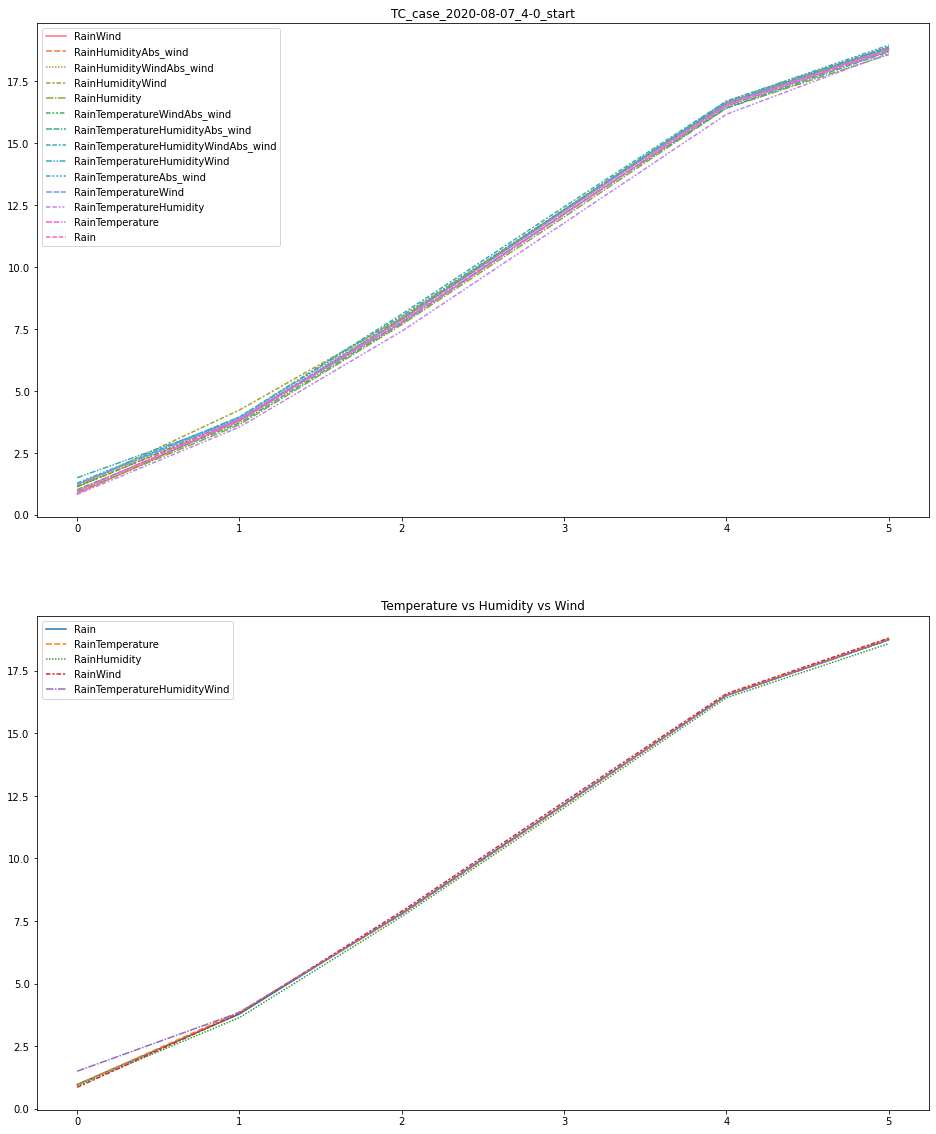

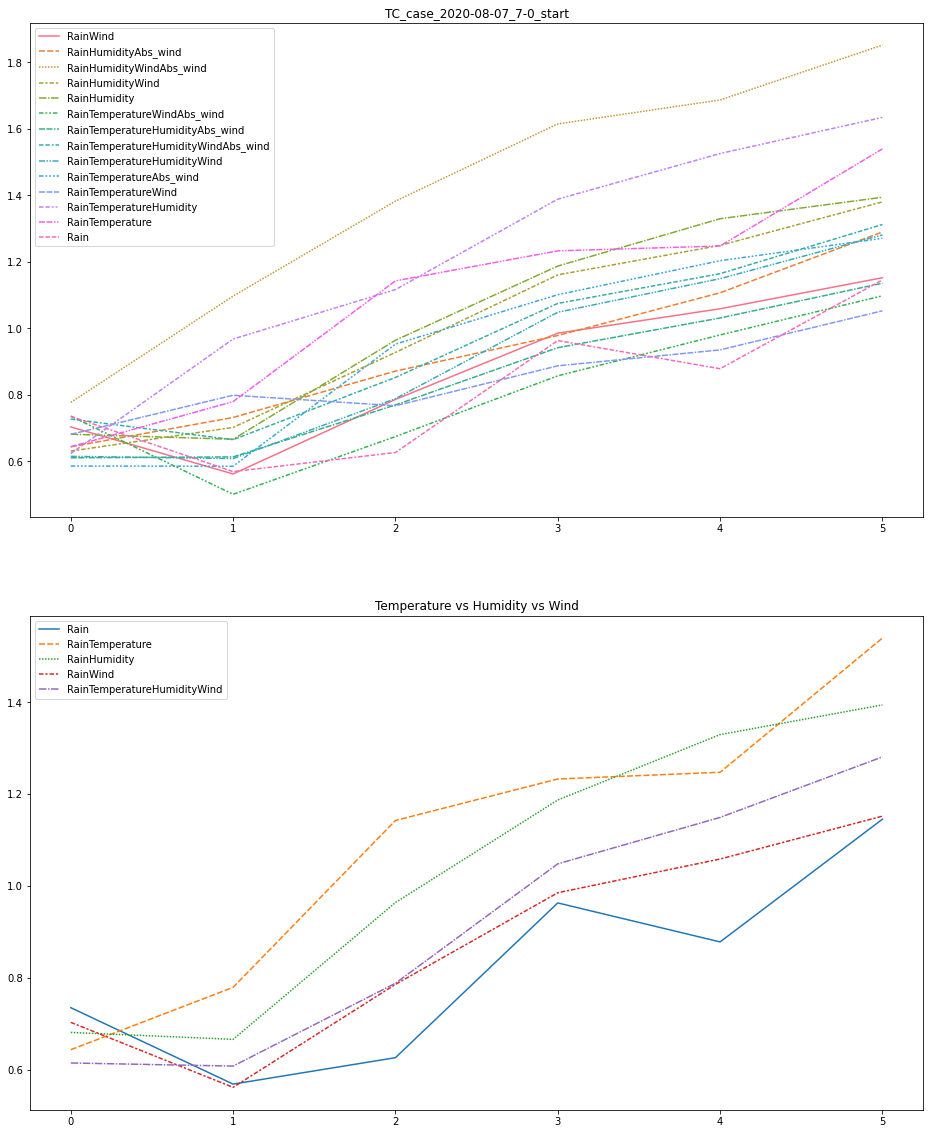

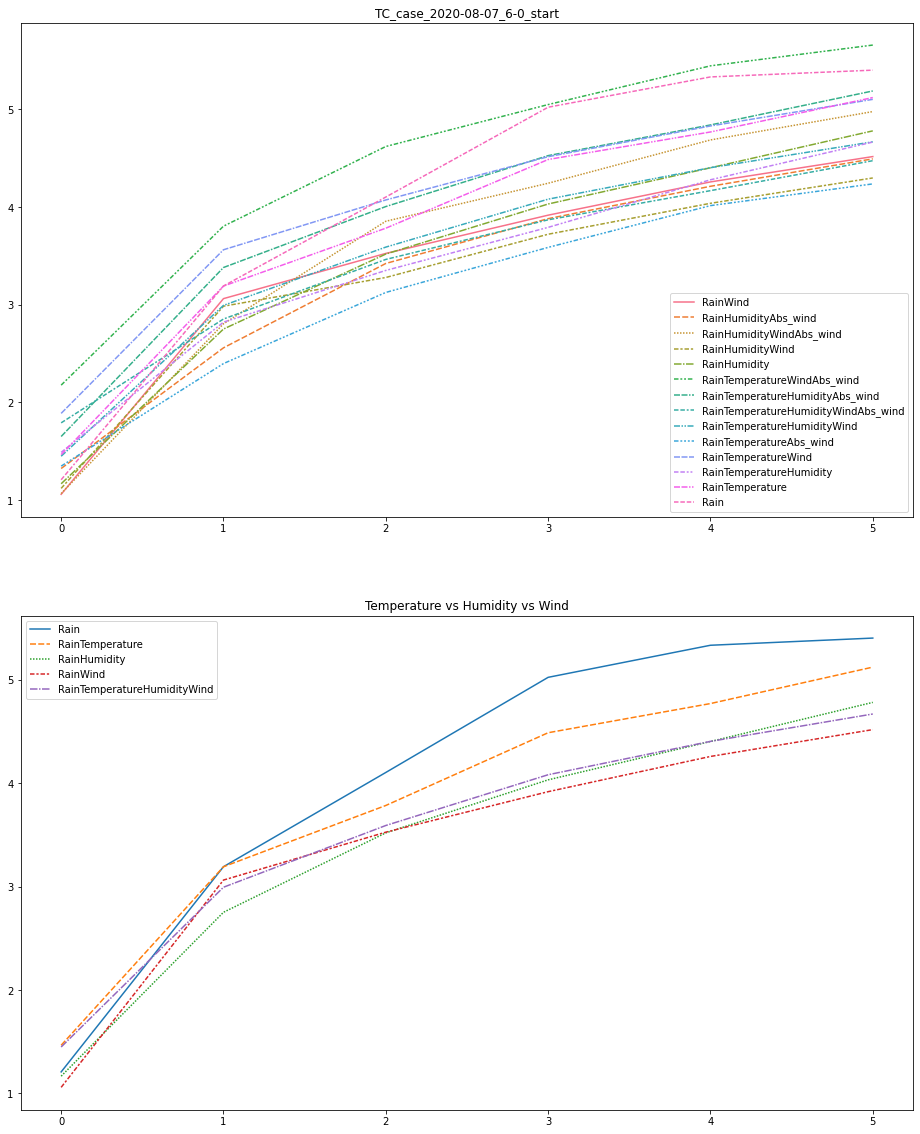

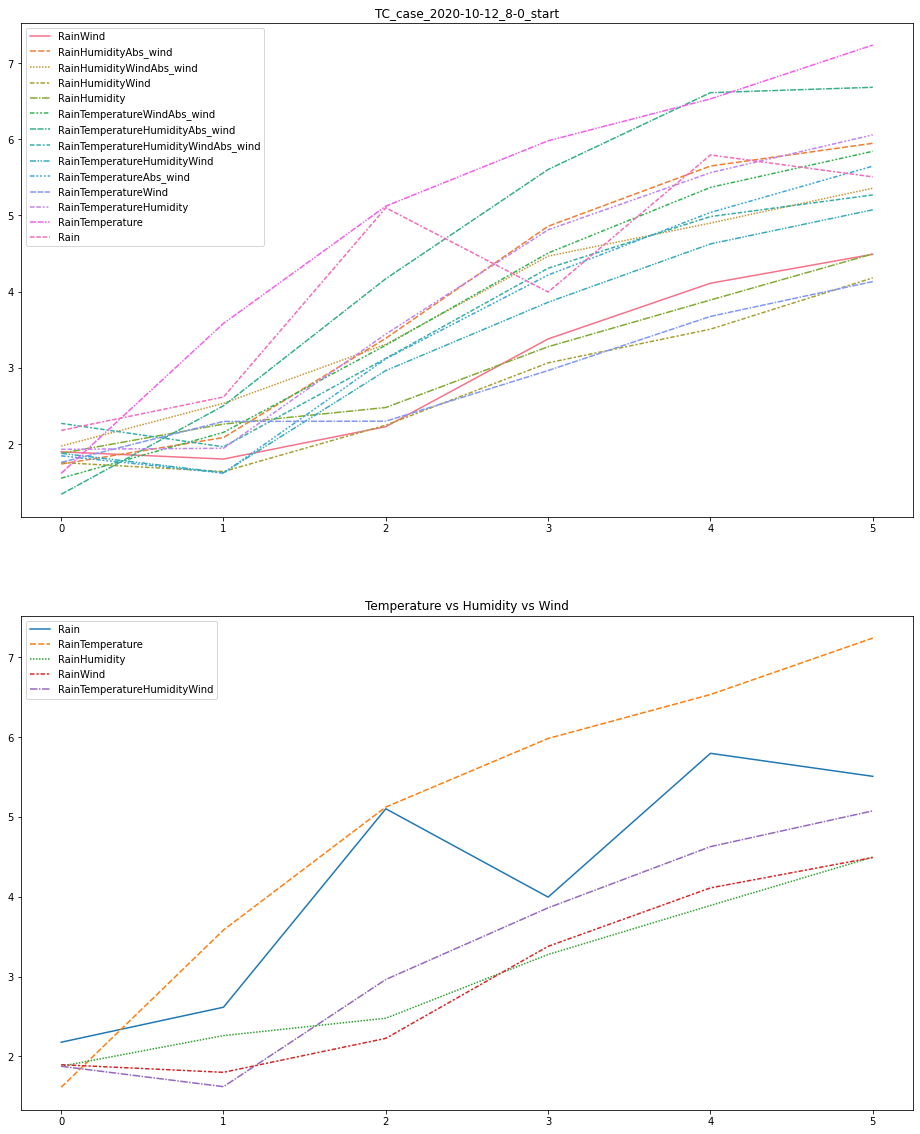

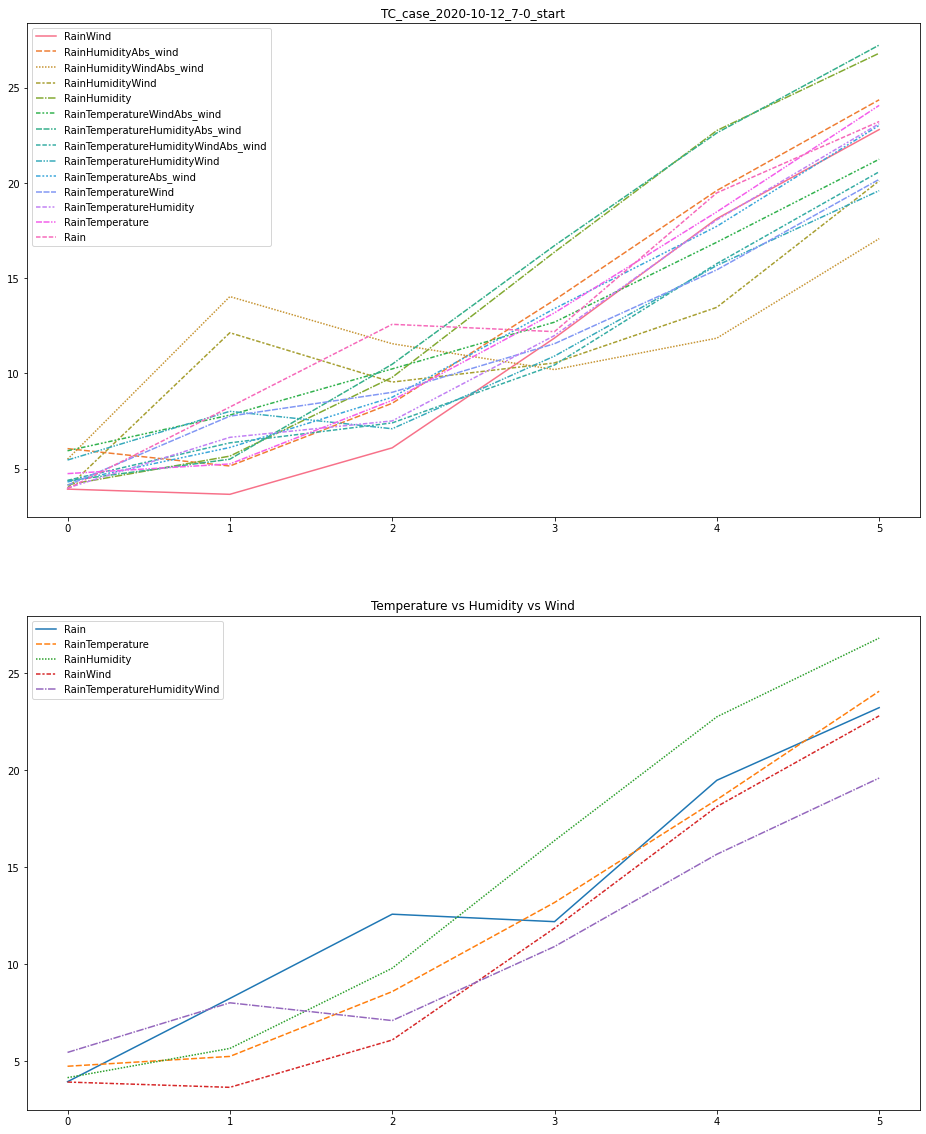

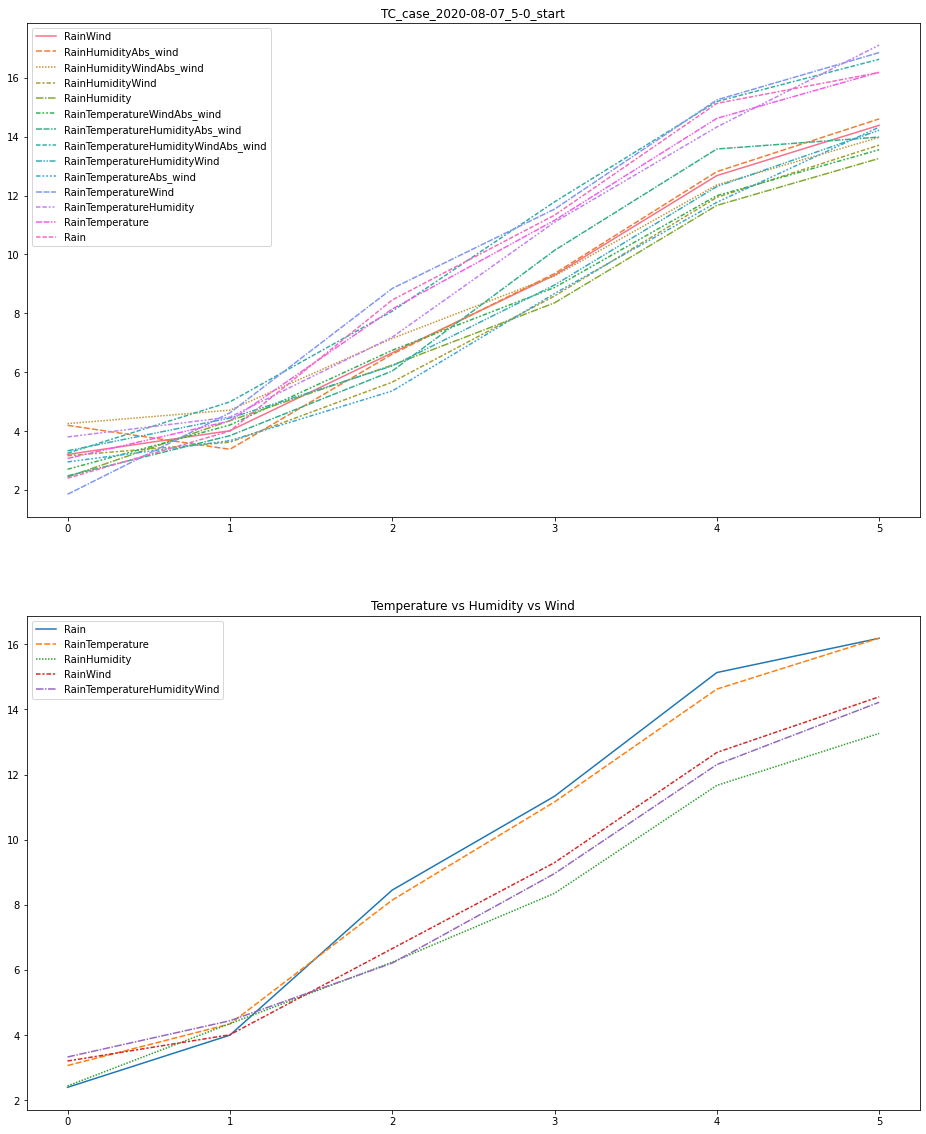

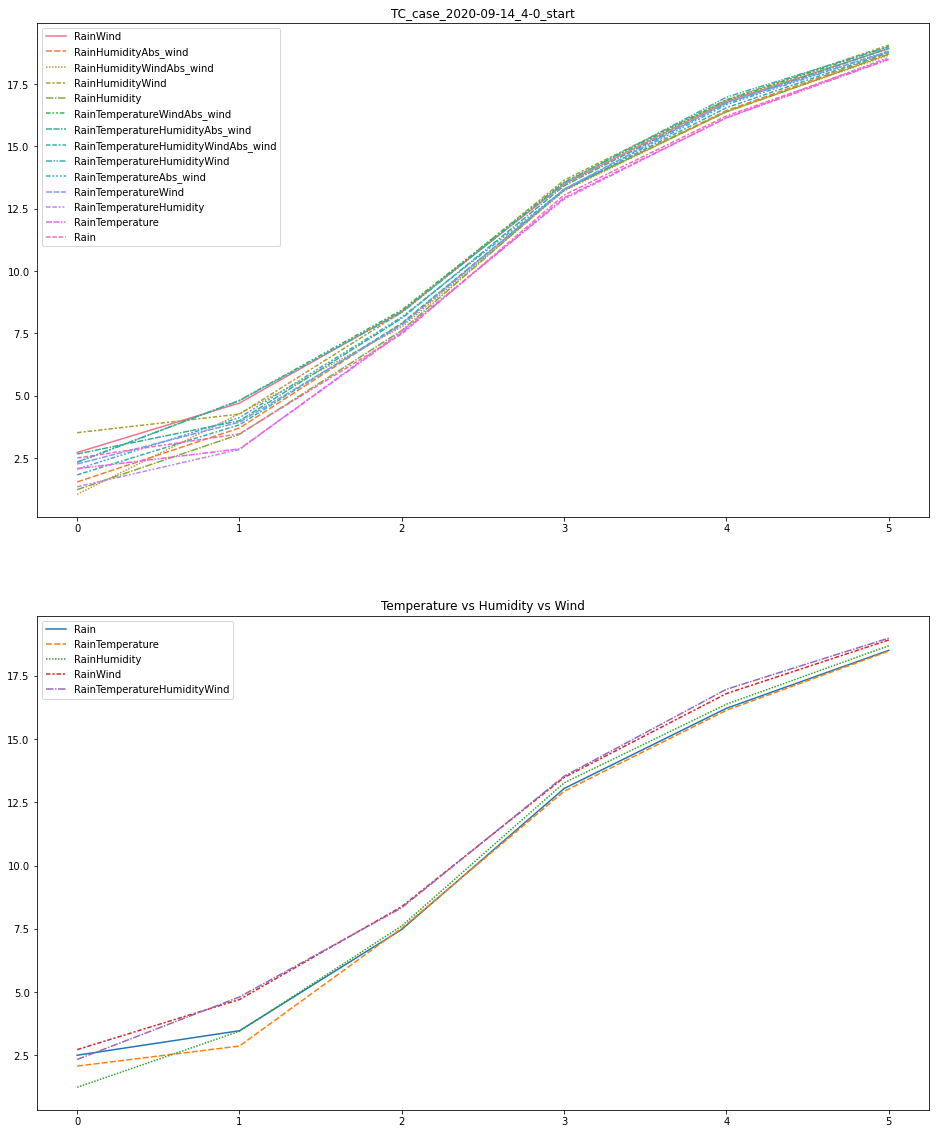

In [20]:
# TC case result

case_names = list(tc_case_rmses["Rain"].keys())
for case_name in case_names:
    df = pd.DataFrame()
    for key, case_result in tc_case_rmses.items():
        target_metrics_dic = case_result[case_name]
        df[key] = [v for k, v in sorted(target_metrics_dic.items(), key=lambda item: item[0])]
    
    # Visualize
    fig, ax = plt.subplots(2, 1, figsize=(16, 20))
    ax = ax.flatten()
    # Compare with all input parameters
    sns.lineplot(data=df, ax=ax[0])
    ax[0].set_title(case_name)
    
    # Select target parameters
    target_cols = ["Rain", "RainTemperature", "RainHumidity", "RainWind", "RainTemperatureHumidityWind"]
    sns.lineplot(data=df[target_cols], ax=ax[1])
    ax[1].set_title("Temperature vs Humidity vs Wind")
    
    plt.savefig(f"./standard_img/{case_name}.png")
    
#     # Compare with temperature
#     ## Temperature
#     hue_columns = [i for i in df.columns if "Temperature" in i]
#     other_columns = [i for i in df.columns if "Temperature" not in i]
    
#     for col in hue_columns:
#         sns.lineplot(data=df, ax=ax[1], x=df.index, y=col, color="orange")
#     for col in other_columns:
#         sns.lineplot(data=df, ax=ax[1], x=df.index, y=col, color="blue")
#     ax[1].set_title("It includes temperature (orange) or not (blue)")
#     ## Humidity
#     hue_columns = [i for i in df.columns if "Humidity" in i]
#     other_columns = [i for i in df.columns if "Humidity" not in i]
    
#     for col in hue_columns:
#         sns.lineplot(data=df, ax=ax[2], x=df.index, y=col, color="orange")
#     for col in other_columns:
#         sns.lineplot(data=df, ax=ax[2], x=df.index, y=col, color="blue")
#     ax[2].set_title("It includes humidity (orange) or not (blue)")
    
#     ## Wind (Wind & Abs_wind)
#     hue_columns = [i for i in df.columns if "Wind" in i or "Abs_wind" in i]
#     other_columns = [i for i in df.columns if "Wind" not in i or "Abs_wind" in i]
    
#     for col in hue_columns:
#         sns.lineplot(data=df, ax=ax[3], x=df.index, y=col, color="orange")
#     for col in other_columns:
#         sns.lineplot(data=df, ax=ax[3], x=df.index, y=col, color="blue")
#     ax[3].set_title("It includes wind (orange) or not (blue)")
    
    plt.show()
    plt.close()

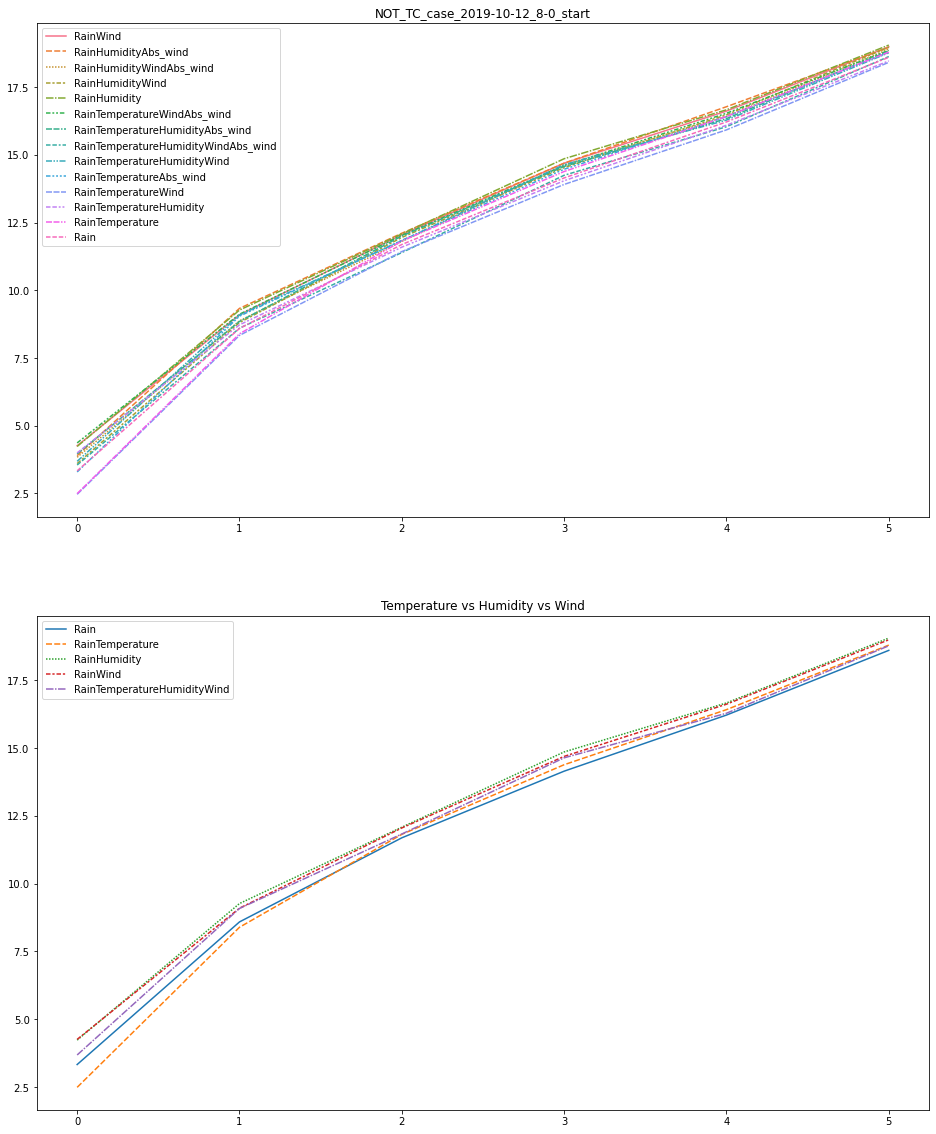

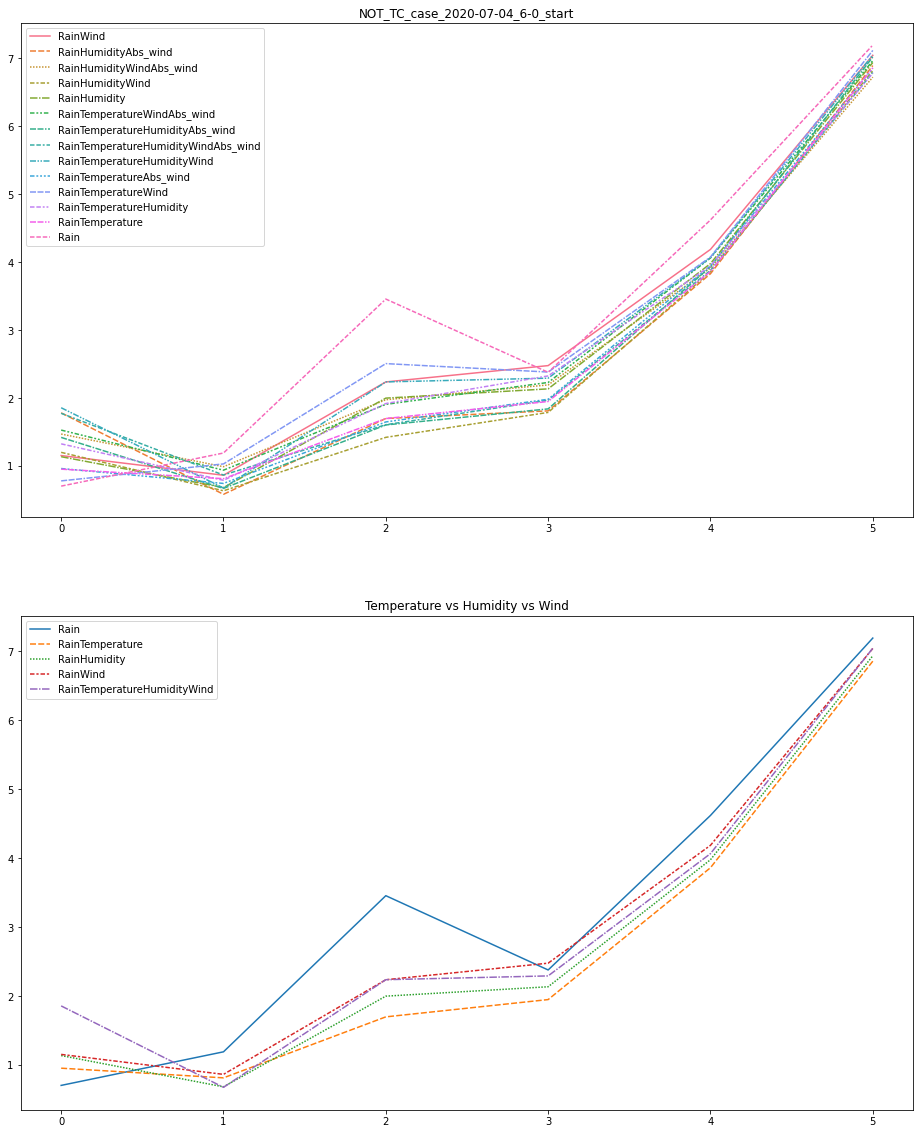

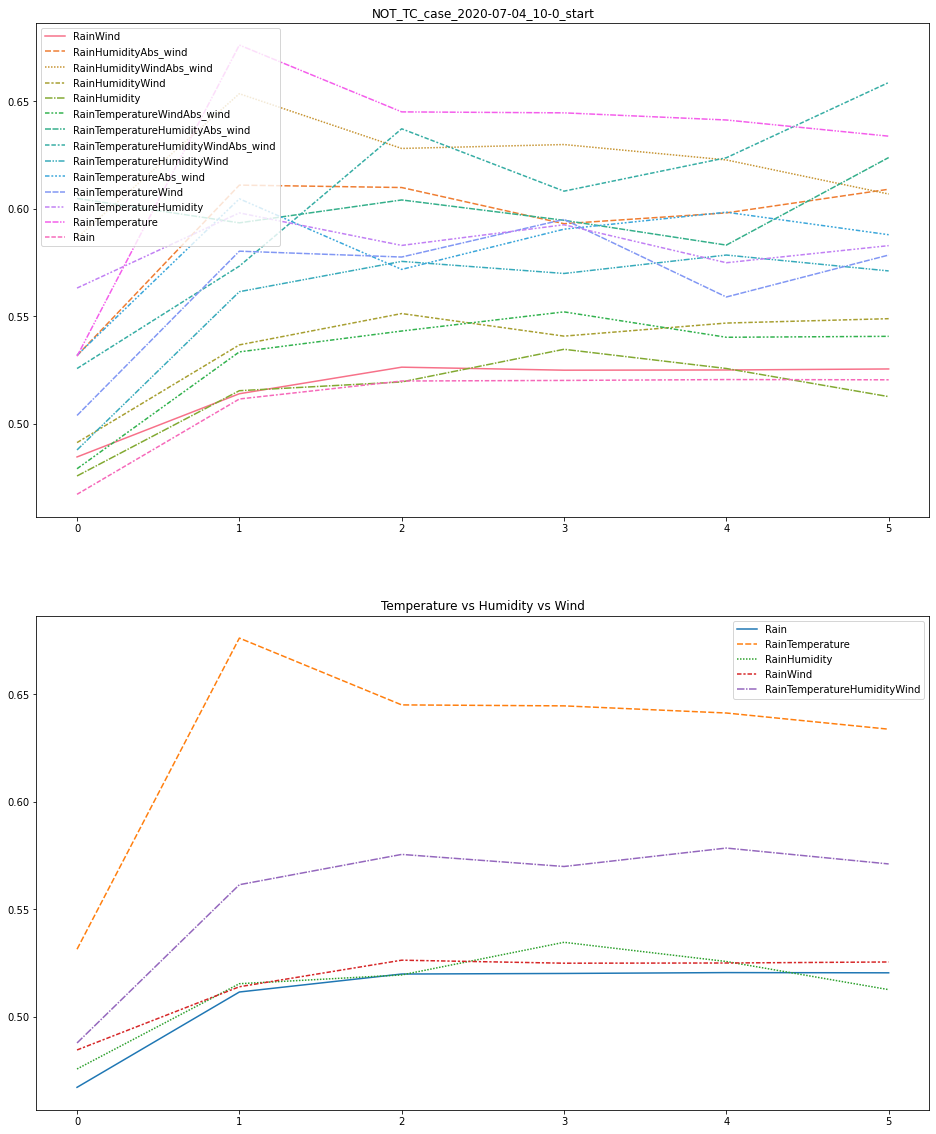

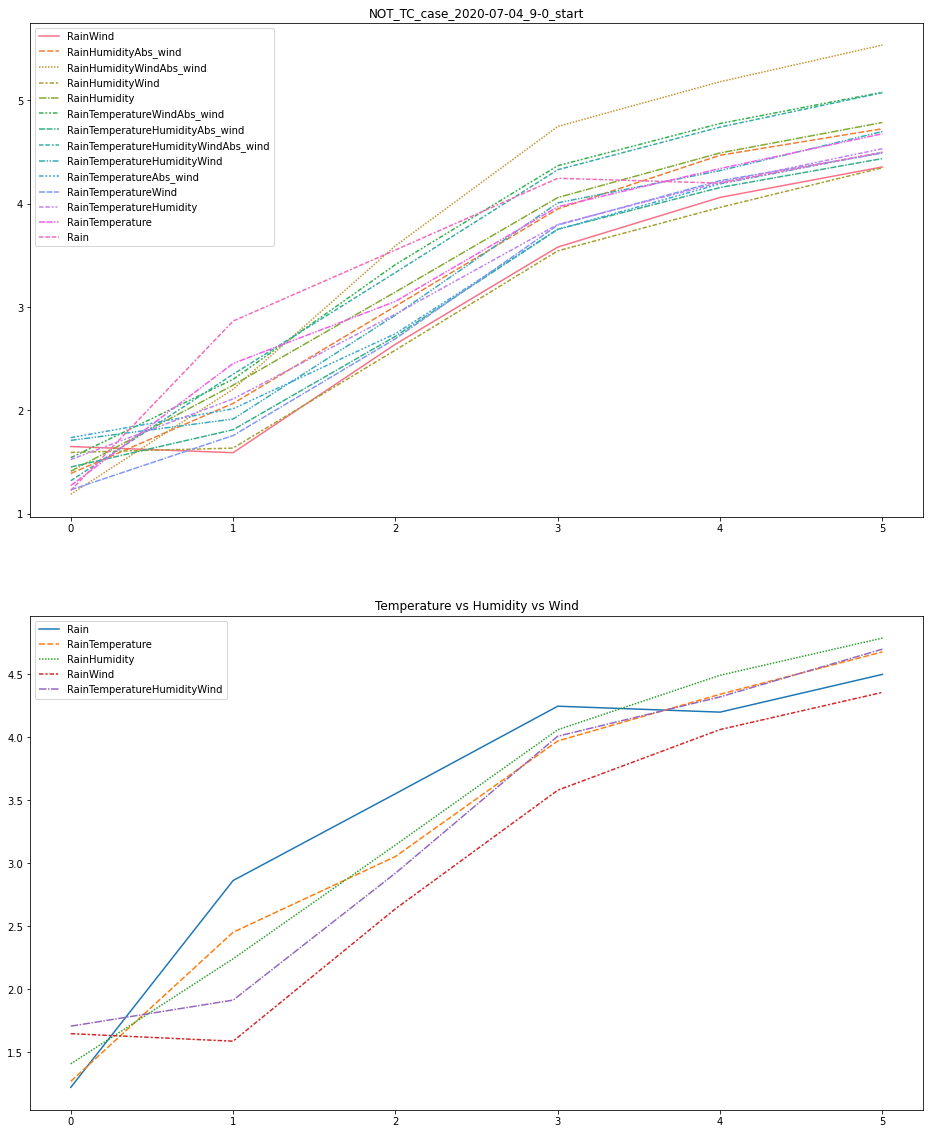

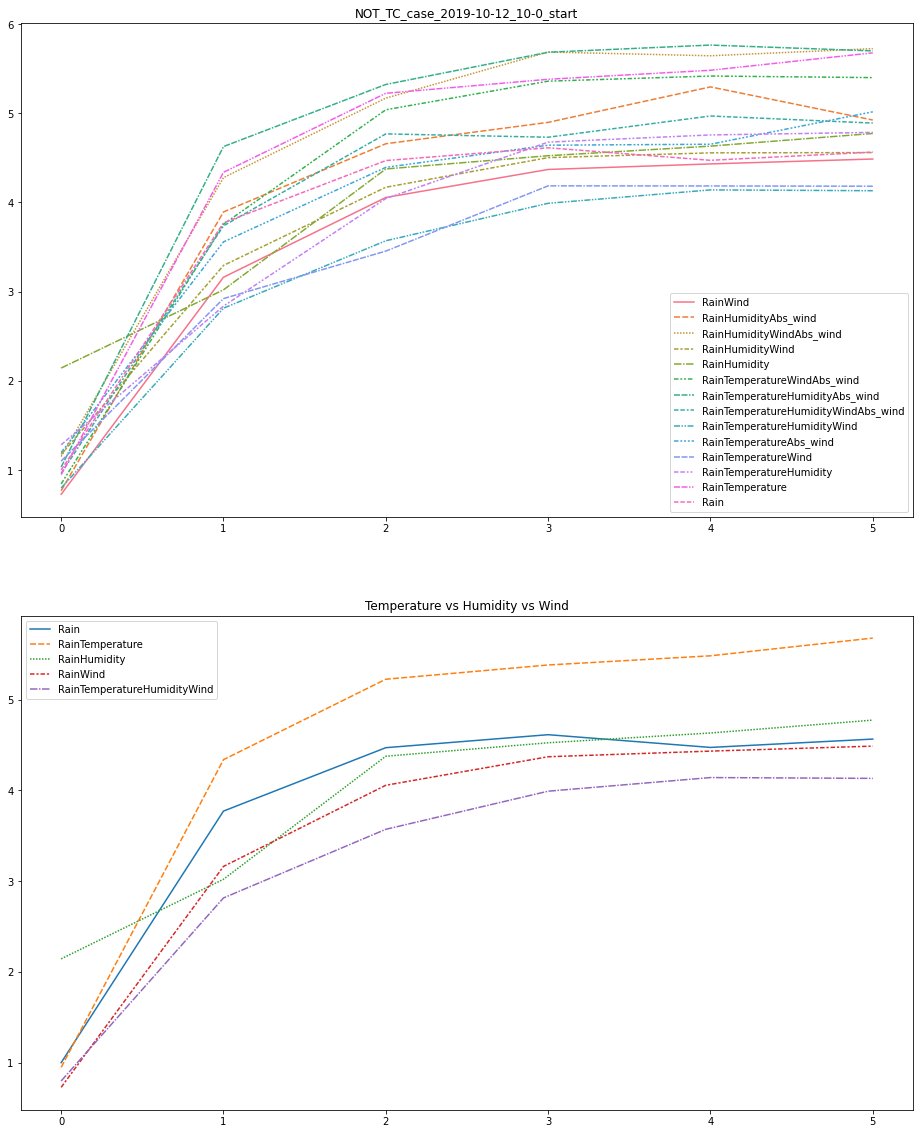

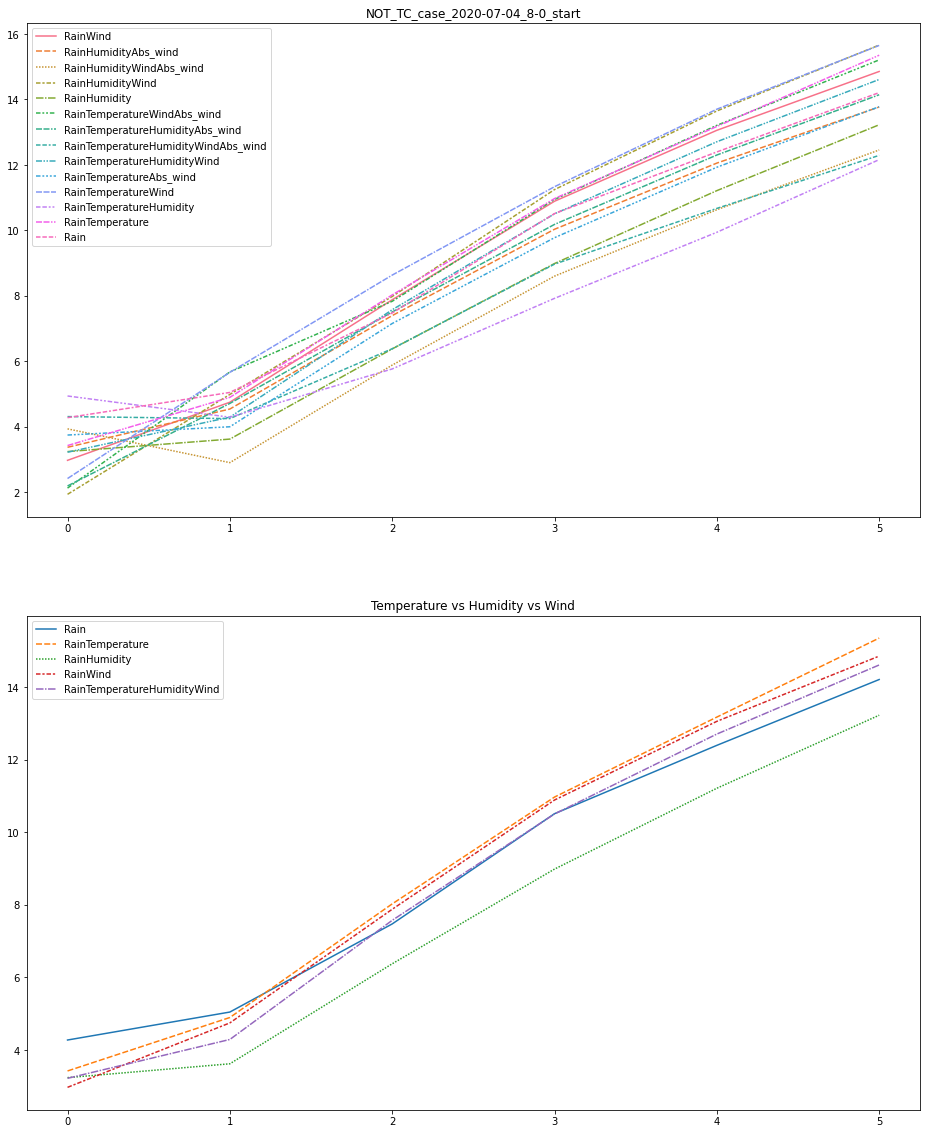

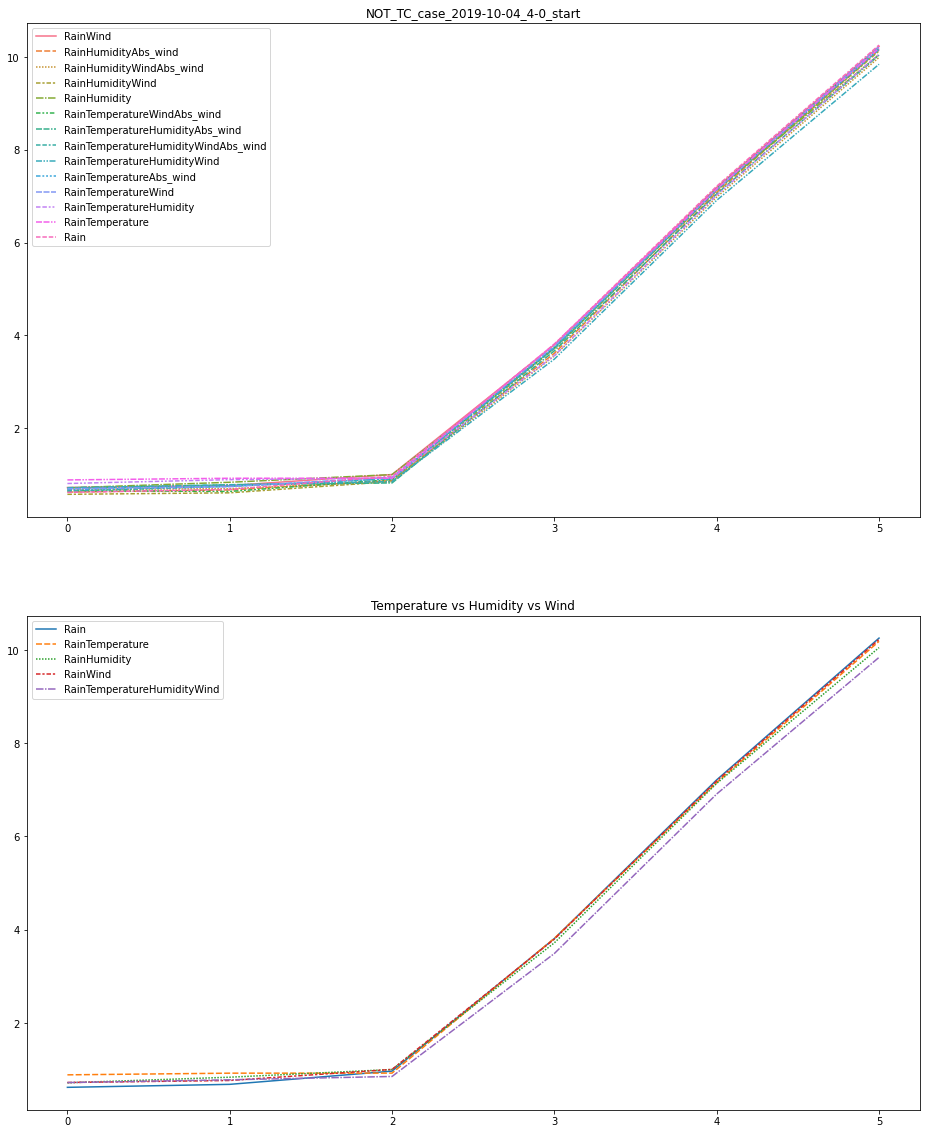

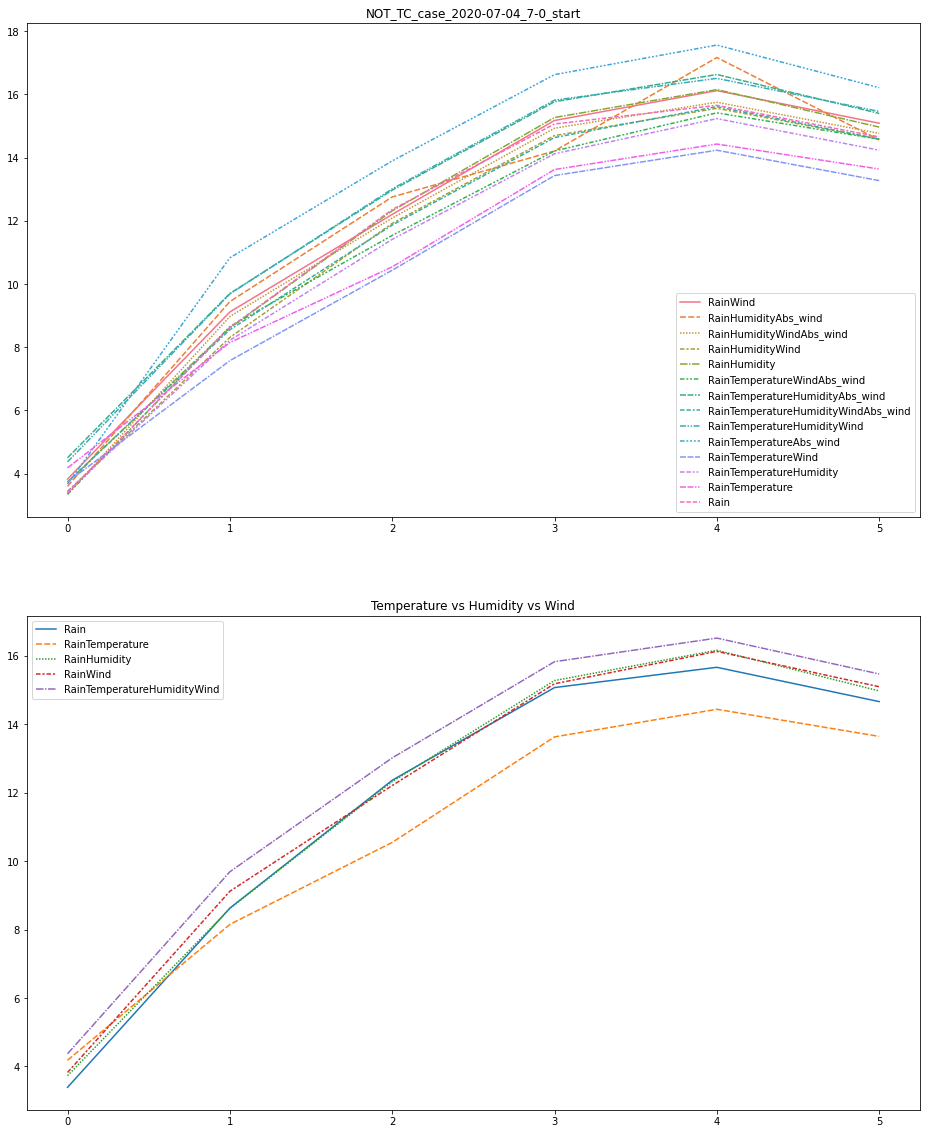

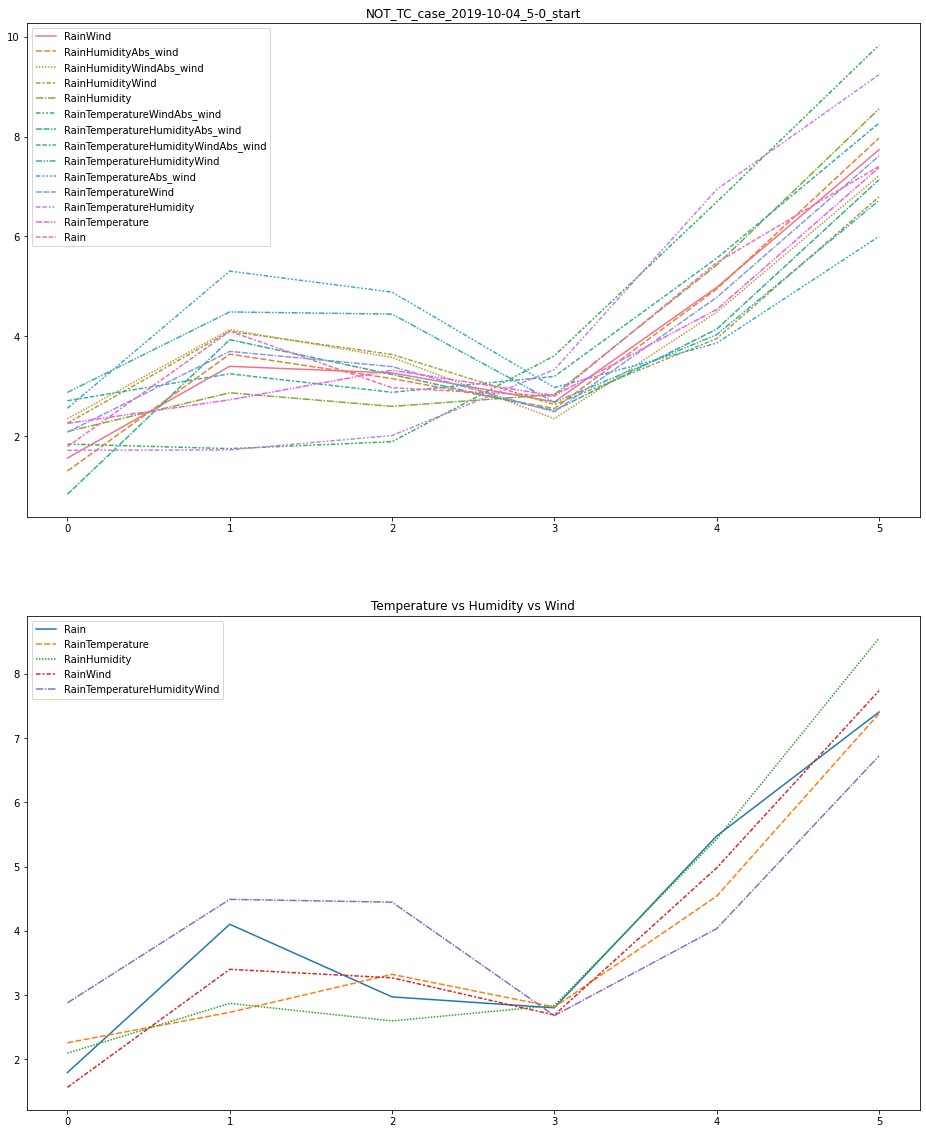

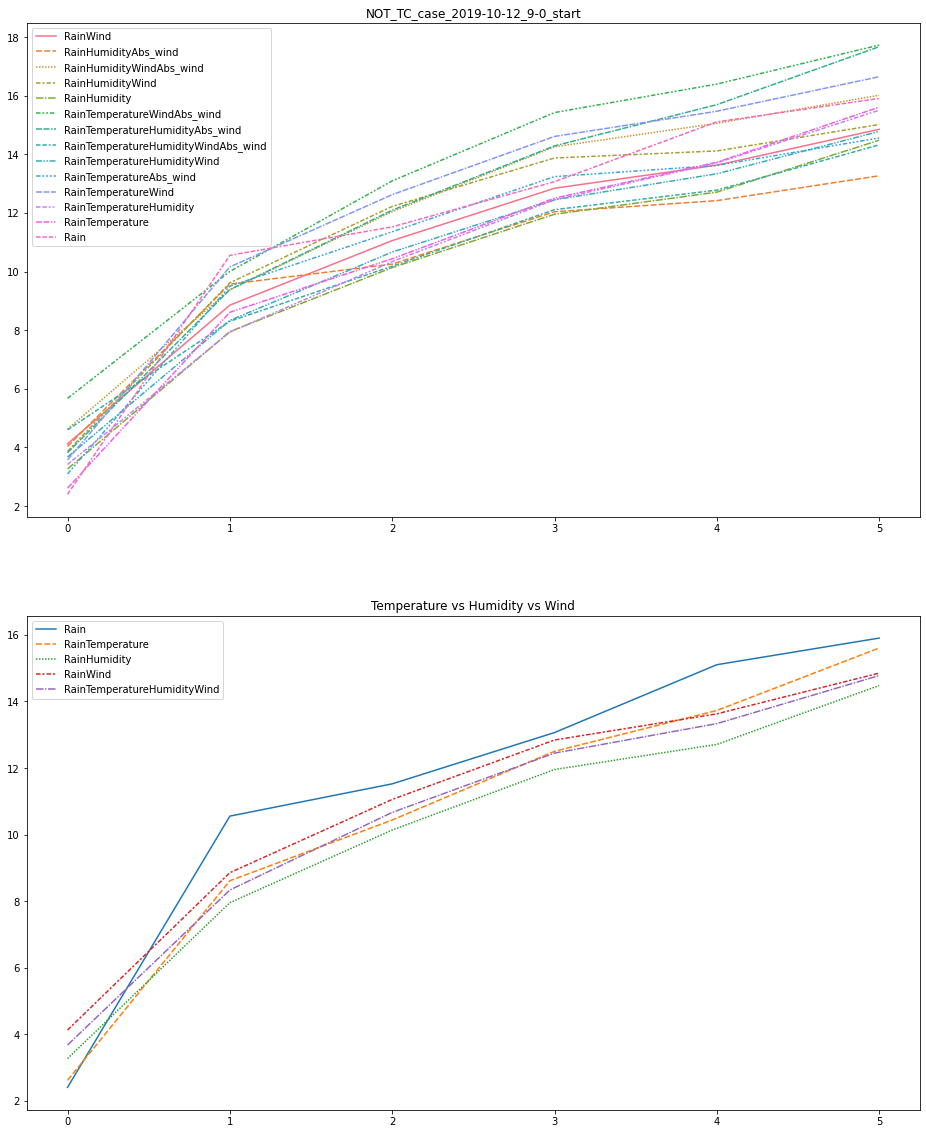

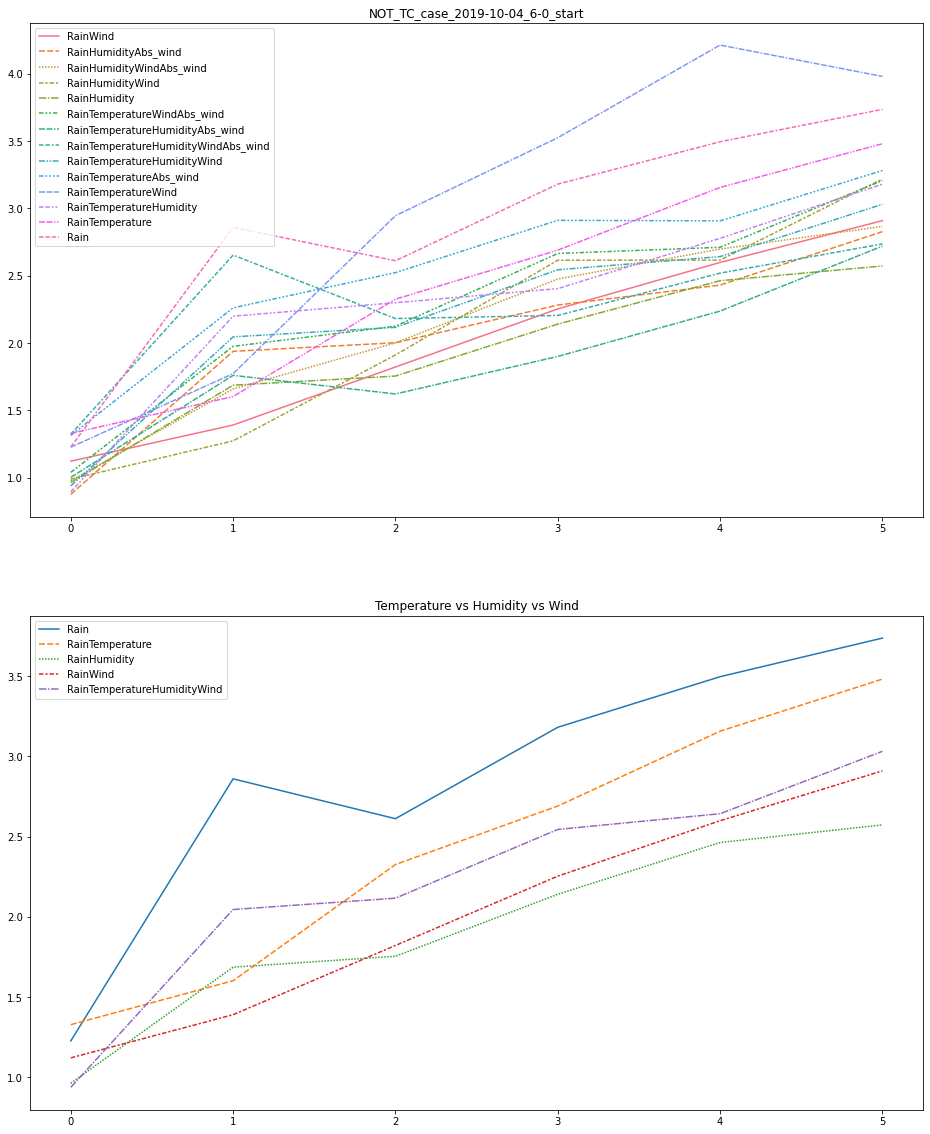

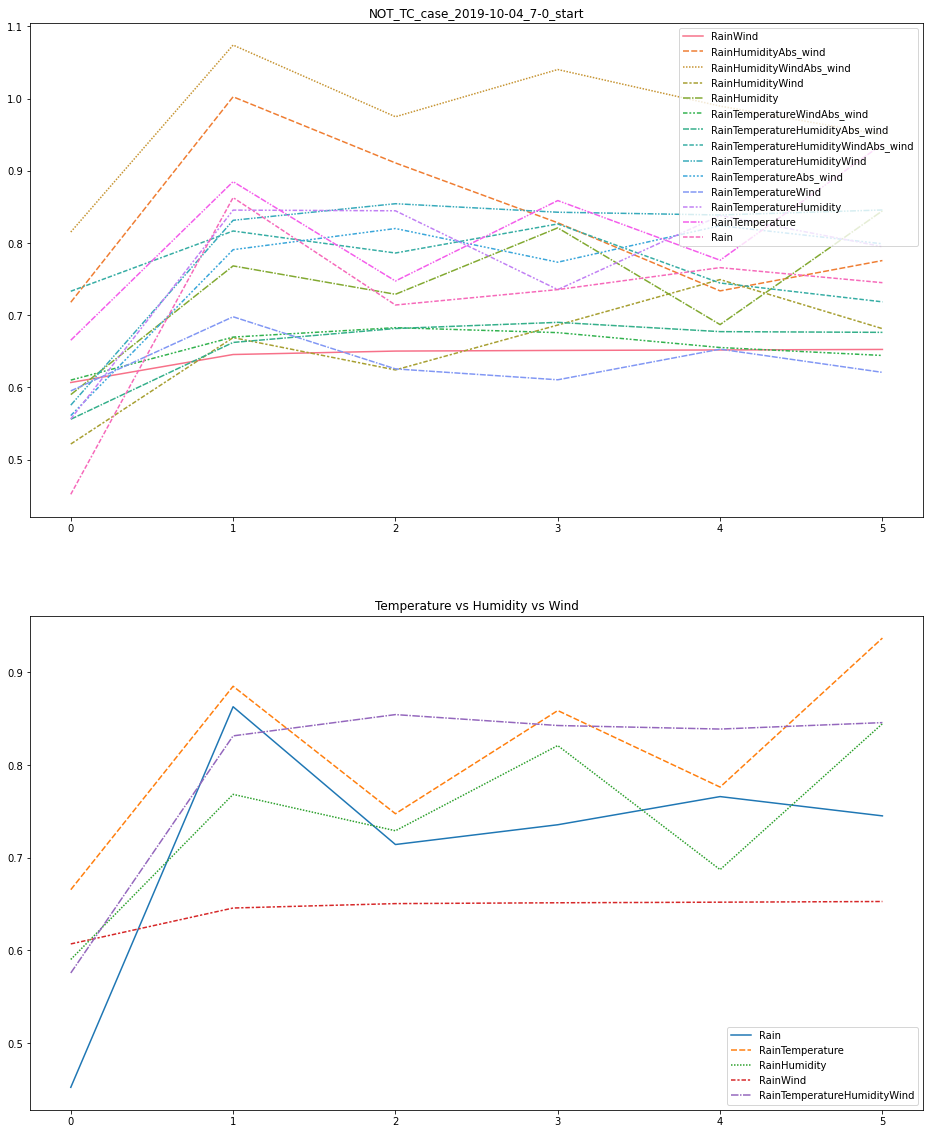

In [21]:
# NOT TC case result

case_names = list(not_tc_case_rmses["Rain"].keys())
for case_name in case_names:
    df = pd.DataFrame()
    for key, case_result in not_tc_case_rmses.items():
        target_metrics_dic = case_result[case_name]
        df[key] = [v for k, v in sorted(target_metrics_dic.items(), key=lambda item: item[0])]
    
    # Visualize
    fig, ax = plt.subplots(2, 1, figsize=(16, 20))
    ax = ax.flatten()
    # Compare with all input parameters
    sns.lineplot(data=df, ax=ax[0])
    ax[0].set_title(case_name)
    
    # Select target parameters
    target_cols = ["Rain", "RainTemperature", "RainHumidity", "RainWind", "RainTemperatureHumidityWind"]
    sns.lineplot(data=df[target_cols], ax=ax[1])
    ax[1].set_title("Temperature vs Humidity vs Wind")
    
    plt.savefig(f"./standard_img/{case_name}.png")
#     # Compare with temperature
#     ## Temperature
#     hue_columns = [i for i in df.columns if "Temperature" in i]
#     other_columns = [i for i in df.columns if "Temperature" not in i]
    
#     for col in hue_columns:
#         sns.lineplot(data=df, ax=ax[1], x=df.index, y=col, color="orange")
#     for col in other_columns:
#         sns.lineplot(data=df, ax=ax[1], x=df.index, y=col, color="blue")
#     ax[1].set_title("It includes temperature (orange) or not (blue)")
#     ## Humidity
#     hue_columns = [i for i in df.columns if "Humidity" in i]
#     other_columns = [i for i in df.columns if "Humidity" not in i]
    
#     for col in hue_columns:
#         sns.lineplot(data=df, ax=ax[2], x=df.index, y=col, color="orange")
#     for col in other_columns:
#         sns.lineplot(data=df, ax=ax[2], x=df.index, y=col, color="blue")
#     ax[2].set_title("It includes humidity (orange) or not (blue)")
    
#     ## Wind (Wind & Abs_wind)
#     hue_columns = [i for i in df.columns if "Wind" in i or "Abs_wind" in i]
#     other_columns = [i for i in df.columns if "Wind" not in i or "Abs_wind" in i]
    
#     for col in hue_columns:
#         sns.lineplot(data=df, ax=ax[3], x=df.index, y=col, color="orange")
#     for col in other_columns:
#         sns.lineplot(data=df, ax=ax[3], x=df.index, y=col, color="blue")
#     ax[3].set_title("It includes wind (orange) or not (blue)")
    
    plt.show()
    plt.close()

RainWind  RainHumidityAbs_wind  RainHumidityWindAbs_wind  \
0   2.718958              1.536629                  1.040283   
1   4.701405              3.701346                  4.275291   
2   8.379383              7.888864                  7.753326   
3  13.482286             13.247696                 13.211776   
4  16.801289             16.431748                 16.394277   

   RainHumidityWind  RainHumidity  RainTemperatureWindAbs_wind  \
0          3.513207      1.228205                     2.332394   
1          4.258083      3.446419                     4.808126   
2          8.346116      7.613721                     8.432619   
3         13.640893     13.270243                    13.557159   
4         16.870840     16.380200                    16.851638   

   RainTemperatureHumidityAbs_wind  RainTemperatureHumidityWindAbs_wind  \
0                         2.657883                             1.820644   
1                         3.991705                             3.830298   
2                         8.104580                             7.903044   
3                        13.418515                            13.248377   
4                        16.734269                            16.546619   

   RainTemperatureHumidityWind  RainTemperatureAbs_wind  RainTemperatureWind  \
0                     2.329044                 2.050561             2.256653   
1                     4.802048                 4.115351             3.933913   
2                     8.333437                 8.149582             7.828591   
3                    13.531884                13.269146            13.276759   
4                    16.970440                16.673374            16.758173   

   RainTemperatureHumidity  RainTemperature       Rain  
0                 1.343432         2.068265   2.498637  
1                 2.838555         2.862086   3.466582  
2                 7.590318         7.523908   7.473708  
3                12.879070        12.936525  13.045660  
4                16.146517        16.140175  16.218057

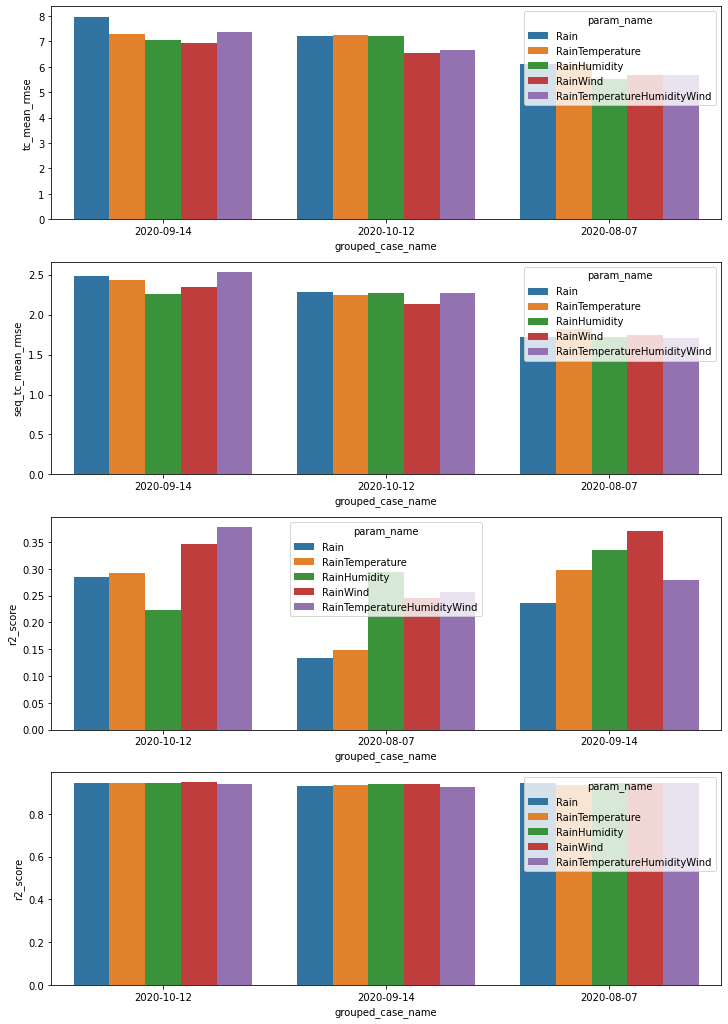

In [25]:
# TC case result
def get_grouped_case_name(case_name: str) -> str:
    if "2020-09-14" in case_name:
        return "2020-09-14"
    elif "2020-08-07" in case_name:
        return "2020-08-07"
    elif "2020-10-12" in case_name:
        return "2020-10-12"
    else:
        return "else"

case_names = list(tc_case_rmses["Rain"].keys())
case_mean_dic = {"tc_mean_rmse": [], "seq_tc_mean_rmse": [], "case_name": [], "param_name": []}
target_cols = ["Rain", "RainTemperature", "RainHumidity", "RainWind", "RainTemperatureHumidityWind"]
for case_name in case_names:
    df = pd.DataFrame()
    for key, case_result in tc_case_rmses.items():
        target_metrics_dic = case_result[case_name]
        df[key] = [v for k, v in sorted(target_metrics_dic.items(), key=lambda item: item[0])]
    seq_df = pd.DataFrame()
    for key, case_result in seq_tc_case_rmses.items():
        target_metrics_dic = case_result[f"Sequential_{case_name}"]
        seq_df[key] = [v for k, v in sorted(target_metrics_dic.items(), key=lambda item: item[0])]
    
    for col in target_cols: 
        case_mean_dic["tc_mean_rmse"] += [df[col].mean()]
        case_mean_dic["seq_tc_mean_rmse"] += [seq_df[col].mean()]
        case_mean_dic["case_name"] += [case_name]
        case_mean_dic["param_name"] += [col]

rmse_df = pd.DataFrame(case_mean_dic)
rmse_df["grouped_case_name"] = rmse_df["case_name"].apply(get_grouped_case_name)

r2_dic = {"r2_score": [], "param_name": [], "case_name": [], "grouped_case_name": []}
seq_r2_dic = {"r2_score": [], "param_name": [], "case_name": [], "grouped_case_name": []}
for col in target_cols:
    target_r2_scores = r2_scores[col]
    for key, val in target_r2_scores.items():
        grouped_case_name = get_grouped_case_name(key)
        if grouped_case_name != "else":
            if "Sequential" in key:
                seq_r2_dic["param_name"].append(col)
                seq_r2_dic["case_name"].append(key)
                seq_r2_dic["grouped_case_name"].append(grouped_case_name)
                seq_r2_dic["r2_score"].append(val)
            else:
                r2_dic["param_name"].append(col)
                r2_dic["case_name"].append(key)
                r2_dic["grouped_case_name"].append(grouped_case_name)
                r2_dic["r2_score"].append(val)

tc_case_r2_df = pd.DataFrame(r2_dic)
seq_tc_case_r2_df = pd.DataFrame(seq_r2_dic)

fig, ax = plt.subplots(4, 1, figsize=(12, 18))
ax = ax.flatten()
sns.barplot(data=rmse_df, x="grouped_case_name", y="tc_mean_rmse", hue="param_name", ci=None, ax=ax[0])
sns.barplot(data=rmse_df, x="grouped_case_name", y="seq_tc_mean_rmse", hue="param_name", ci=None, ax=ax[1])
sns.barplot(data=tc_case_r2_df, x="grouped_case_name", y="r2_score", hue="param_name", ci=None, ax=ax[2])
sns.barplot(data=seq_tc_case_r2_df, x="grouped_case_name", y="r2_score", hue="param_name", ci=None, ax=ax[3])
# Use Barplot with grouping

plt.savefig(f"./standard_img/tc_case_r2_scores.png")

df.head()

In [15]:
tc_case_r2_df

r2_score                   param_name            case_name  \
0      0.285                         Rain  r2_2020-10-12_cases   
1      0.134                         Rain  r2_2020-08-07_cases   
2      0.236                         Rain  r2_2020-09-14_cases   
3      0.293              RainTemperature  r2_2020-10-12_cases   
4      0.149              RainTemperature  r2_2020-08-07_cases   
5      0.297              RainTemperature  r2_2020-09-14_cases   
6      0.224                 RainHumidity  r2_2020-10-12_cases   
7      0.295                 RainHumidity  r2_2020-08-07_cases   
8      0.335                 RainHumidity  r2_2020-09-14_cases   
9      0.346                     RainWind  r2_2020-10-12_cases   
10     0.245                     RainWind  r2_2020-08-07_cases   
11     0.370                     RainWind  r2_2020-09-14_cases   
12     0.378  RainTemperatureHumidityWind  r2_2020-10-12_cases   
13     0.257  RainTemperatureHumidityWind  r2_2020-08-07_cases   
14     0.280  RainTemperatureHumidityWind  r2_2020-09-14_cases   

   grouped_case_name  
0         2020-10-12  
1         2020-08-07  
2         2020-09-14  
3         2020-10-12  
4         2020-08-07  
5         2020-09-14  
6         2020-10-12  
7         2020-08-07  
8         2020-09-14  
9         2020-10-12  
10        2020-08-07  
11        2020-09-14  
12        2020-10-12  
13        2020-08-07  
14        2020-09-14

RainWind  RainHumidityAbs_wind  RainHumidityWindAbs_wind  RainHumidityWind  \
0  0.606857              0.717959                  0.815223          0.521703   
1  0.645620              1.002432                  1.074063          0.668995   
2  0.650377              0.910875                  0.974811          0.624273   
3  0.651279              0.828034                  1.040173          0.686416   
4  0.651914              0.733703                  0.989541          0.749385   

   RainHumidity  RainTemperatureWindAbs_wind  RainTemperatureHumidityAbs_wind  \
0      0.590109                     0.610192                         0.555999   
1      0.768295                     0.669727                         0.662345   
2      0.729026                     0.682764                         0.681619   
3      0.820972                     0.675919                         0.690147   
4      0.687036                     0.655298                         0.677303   

   RainTemperatureHumidityWindAbs_wind  RainTemperatureHumidityWind  \
0                             0.733218                     0.575510   
1                             0.816634                     0.831439   
2                             0.786159                     0.854398   
3                             0.826409                     0.842617   
4                             0.744609                     0.838787   

   RainTemperatureAbs_wind  RainTemperatureWind  RainTemperatureHumidity  \
0                 0.561074             0.595223                 0.556377   
1                 0.790744             0.697864                 0.845553   
2                 0.820060             0.625712                 0.844614   
3                 0.773425             0.610632                 0.735477   
4                 0.823993             0.653023                 0.838141   

   RainTemperature      Rain  
0         0.665413  0.452057  
1         0.884981  0.862882  
2         0.747392  0.714158  
3         0.858764  0.735500  
4         0.776171  0.765900

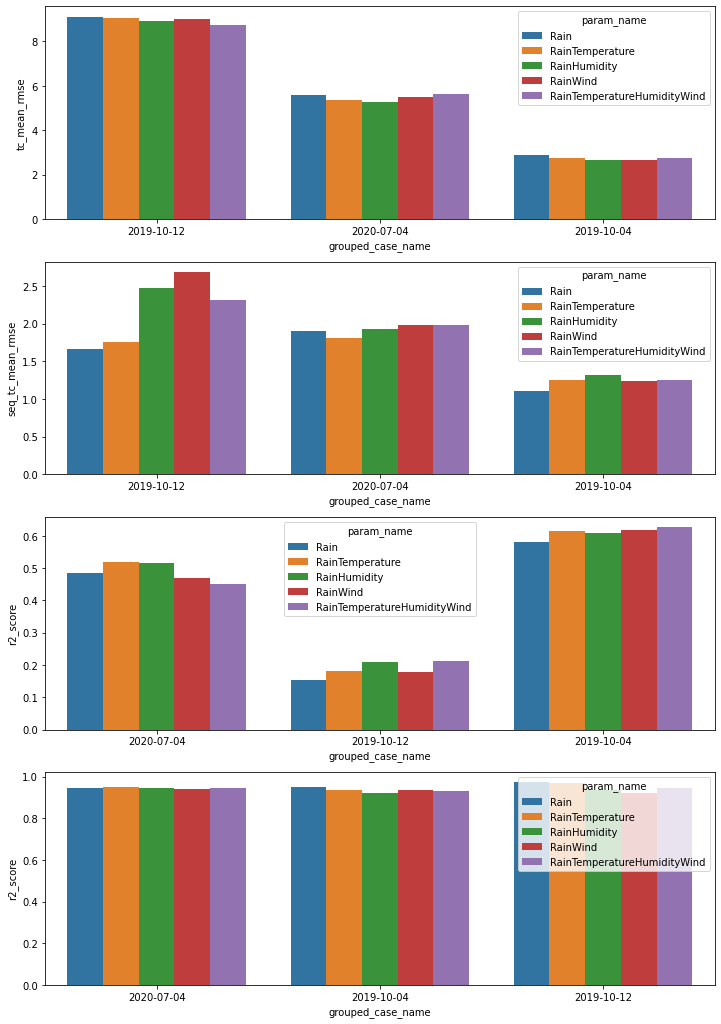

In [24]:
# NOT TC case result
def get_grouped_case_name(case_name: str) -> str:
    if "2019-10-04" in case_name:
        return "2019-10-04"
    elif "2020-07-04" in case_name:
        return "2020-07-04"
    elif "2019-10-12" in case_name:
        return "2019-10-12"
    else:
        return "else"

case_names = list(not_tc_case_rmses["Rain"].keys())
case_mean_dic = {"tc_mean_rmse": [], "seq_tc_mean_rmse": [], "case_name": [], "param_name": []}
target_cols = ["Rain", "RainTemperature", "RainHumidity", "RainWind", "RainTemperatureHumidityWind"]
for case_name in case_names:
    df = pd.DataFrame()
    for key, case_result in not_tc_case_rmses.items():
        target_metrics_dic = case_result[case_name]
        df[key] = [v for k, v in sorted(target_metrics_dic.items(), key=lambda item: item[0])]
    seq_df = pd.DataFrame()
    for key, case_result in seq_not_tc_case_rmses.items():
        target_metrics_dic = case_result[f"Sequential_{case_name}"]
        seq_df[key] = [v for k, v in sorted(target_metrics_dic.items(), key=lambda item: item[0])]
    
    for col in target_cols: 
        case_mean_dic["tc_mean_rmse"] += [df[col].mean()]
        case_mean_dic["seq_tc_mean_rmse"] += [seq_df[col].mean()]
        case_mean_dic["case_name"] += [case_name]
        case_mean_dic["param_name"] += [col]

rmse_df = pd.DataFrame(case_mean_dic)
rmse_df["grouped_case_name"] = rmse_df["case_name"].apply(get_grouped_case_name)

r2_dic = {"r2_score": [], "param_name": [], "case_name": [], "grouped_case_name": []}
seq_r2_dic = {"r2_score": [], "param_name": [], "case_name": [], "grouped_case_name": []}
for col in target_cols:
    target_r2_scores = r2_scores[col]
    for key, val in target_r2_scores.items():
        grouped_case_name = get_grouped_case_name(key)
        if grouped_case_name != "else":
            if "Sequential" in key:
                seq_r2_dic["param_name"].append(col)
                seq_r2_dic["case_name"].append(key)
                seq_r2_dic["grouped_case_name"].append(grouped_case_name)
                seq_r2_dic["r2_score"].append(val)
            else:
                r2_dic["param_name"].append(col)
                r2_dic["case_name"].append(key)
                r2_dic["grouped_case_name"].append(grouped_case_name)
                r2_dic["r2_score"].append(val)

not_tc_case_r2_df = pd.DataFrame(r2_dic)
seq_tc_case_r2_df = pd.DataFrame(seq_r2_dic)

fig, ax = plt.subplots(4, 1, figsize=(12, 18))
ax = ax.flatten()
sns.barplot(data=rmse_df, x="grouped_case_name", y="tc_mean_rmse", hue="param_name", ci=None, ax=ax[0])
sns.barplot(data=rmse_df, x="grouped_case_name", y="seq_tc_mean_rmse", hue="param_name", ci=None, ax=ax[1])
sns.barplot(data=not_tc_case_r2_df, x="grouped_case_name", y="r2_score", hue="param_name", ci=None, ax=ax[2])
sns.barplot(data=seq_tc_case_r2_df, x="grouped_case_name", y="r2_score", hue="param_name", ci=None, ax=ax[3])
# Use Barplot with grouping

plt.savefig(f"./standard_img/not_tc_case_r2_scores.png")
df.head()